<a href="https://colab.research.google.com/github/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/blob/master/starter_notebook_11_11_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [41]:
"""
you will be forecasting real estate prices of various zip codes 

What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
print('Colab Notebook 11-11-12')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

Colab Notebook


In [42]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [43]:
# #pd.set_option('display.max_columns', None)  
# zillow = pd.read_csv('zillow_data.csv')
# zillow.head()
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
zillow = pd.read_csv('/content/gdrive/My Drive/data/zillow_data.csv') 

In [45]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,...,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,...,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,...,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,...,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,77900.0,77900.0,77800.0,77800.0,77800.0,77800.0,77800.0,77900.0,78100.0,78200.0,78400.0,78600.0,78800.0,79000.0,79100.0,79200.0,79300.0,79300.0,79300.0,79400.0,79500.0,79500.0,79600.0,...,114700,115000,115000,115200,115600,115900,115600,115400,115400,115500,115800,116300,116200,115600,115000,114500,114200,114000,114000,113900,114100,114900,115700,116300,116900,117300,117600,118000,118600,118900,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [46]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [47]:
all_zipcodes = melt_data(zillow)

In [48]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [49]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [50]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [51]:
test_dict = {}

# for zipcode in kings_zips['Zipcode'].unique(): 
#     all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
#     all_zips = all_zips.set_index('Month')['MeanValue']
#     all_zips = all_zips.asfreq('MS')
#     all_zips.name = zipcode
#     test_dict[zipcode] = all_zips
for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [52]:
test_dict

{11203: Month
 1996-04-01    149000.0
 1996-05-01    149200.0
 1996-06-01    149400.0
 1996-07-01    149600.0
 1996-08-01    149700.0
                 ...   
 2017-12-01    474500.0
 2018-01-01    475300.0
 2018-02-01    474800.0
 2018-03-01    481000.0
 2018-04-01    489900.0
 Freq: MS, Name: 11203, Length: 265, dtype: float64, 11204: Month
 1996-04-01    201100.0
 1996-05-01    201100.0
 1996-06-01    201100.0
 1996-07-01    201100.0
 1996-08-01    201100.0
                 ...   
 2017-12-01    958900.0
 2018-01-01    963200.0
 2018-02-01    967900.0
 2018-03-01    972800.0
 2018-04-01    976400.0
 Freq: MS, Name: 11204, Length: 265, dtype: float64, 11205: Month
 2004-01-01     833100.0
 2004-02-01     821400.0
 2004-03-01     812000.0
 2004-04-01     805500.0
 2004-05-01     801400.0
                 ...    
 2017-12-01    2251000.0
 2018-01-01    2251600.0
 2018-02-01    2245300.0
 2018-03-01    2243700.0
 2018-04-01    2248400.0
 Freq: MS, Name: 11205, Length: 172, dtype: float64

In [53]:
zip_df = pd.concat(test_dict, axis=1)

In [54]:
len(zip_df)

265

In [55]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,133200.0,124500.0,160900.0,177200.0,207600.0,126800.0,201100.0,213200.0,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,132900.0,124500.0,161000.0,177000.0,208000.0,126700.0,201100.0,212600.0,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,132500.0,124500.0,161200.0,176800.0,208400.0,126700.0,201100.0,211900.0,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,132200.0,124500.0,161300.0,176700.0,208800.0,126600.0,201100.0,211300.0,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,131800.0,124700.0,161500.0,176800.0,209300.0,126600.0,201100.0,210800.0,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [56]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,1463100.0,809800.0,453600.0,1186400.0,947800.0,435400.0,958900.0,1016000.0,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,1496100.0,800800.0,458400.0,1174500.0,952100.0,429900.0,963200.0,1014400.0,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,1531100.0,806100.0,461600.0,1173900.0,966600.0,432300.0,967900.0,1023800.0,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,1581900.0,829200.0,467200.0,1196100.0,997000.0,442400.0,972800.0,1053000.0,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,1623700.0,852300.0,472000.0,1220900.0,1026600.0,450600.0,976400.0,1079600.0,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [57]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [58]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

In [59]:
zip_df.bfill(inplace=True)

In [60]:
zip_df.isna().sum()

11226    0
11235    0
11230    0
11209    0
11212    0
11214    0
11221    0
11229    0
11234    0
11215    0
11211    0
11233    0
11236    0
11218    0
11223    0
11208    0
11204    0
11219    0
11203    0
11220    0
11216    0
11210    0
11224    0
11222    0
11228    0
11238    0
11205    0
11217    0
dtype: int64

In [61]:
zip_df[11205].value_counts(dropna=False)

833100.0     94
1290900.0     2
2351000.0     2
1355000.0     2
2248400.0     2
             ..
1411700.0     1
1036600.0     1
1659500.0     1
1345800.0     1
1258500.0     1
Name: 11205, Length: 168, dtype: int64

In [62]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [63]:
zip_df[11214].head()

Month
1996-04-01    191000.0
1996-05-01    191200.0
1996-06-01    191500.0
1996-07-01    191900.0
1996-08-01    192100.0
Freq: MS, Name: 11214, dtype: float64

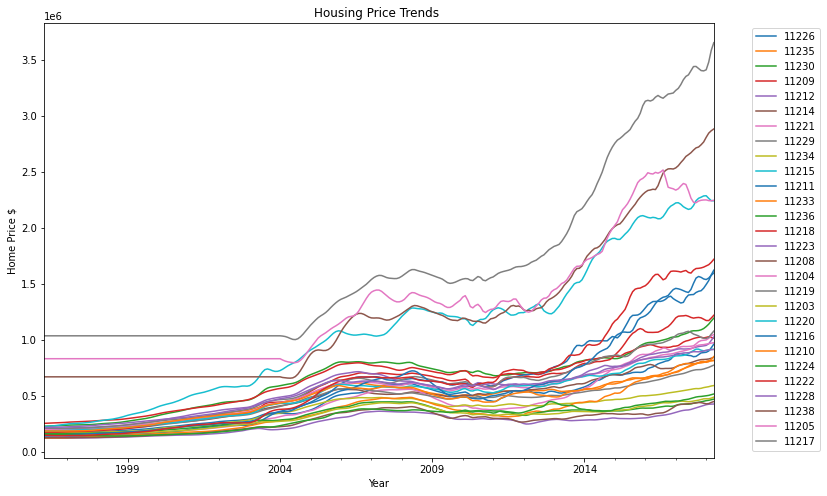

In [64]:
"""

2007–08 Housing Market Crash
"""
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Price $')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [65]:
year = '01-01-2014'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [66]:
test_brk

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,11211,11233,11236,11218,11223,11208,11204,11219,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,580700.0,558200.0,819000.0,813900.0,285200.0,612200.0,569100.0,537700.0,441500.0,1577500.0,958000.0,444700.0,376700.0,791600.0,701300.0,326800.0,680100.0,779800.0,361000.0,674600.0,777900.0,561500.0,380800.0,924400.0,685900.0,1709200.0,1700200.0,2202400.0
2014-02-01,590500.0,560000.0,822500.0,822200.0,286800.0,621100.0,577700.0,541600.0,444400.0,1623300.0,981200.0,450000.0,376700.0,789200.0,715300.0,328600.0,686300.0,784700.0,360700.0,680800.0,792400.0,565400.0,376900.0,954100.0,692700.0,1748800.0,1718500.0,2238400.0
2014-03-01,602600.0,562300.0,823200.0,827400.0,287000.0,632100.0,584600.0,545000.0,446100.0,1673000.0,994000.0,454300.0,375100.0,787900.0,726400.0,328100.0,690100.0,792500.0,359900.0,684500.0,810600.0,565800.0,372100.0,959900.0,695800.0,1773300.0,1727000.0,2271000.0
2014-04-01,618300.0,566300.0,824000.0,829200.0,286500.0,641600.0,600100.0,548300.0,446500.0,1716700.0,993000.0,453200.0,371900.0,795500.0,732700.0,329200.0,693100.0,804800.0,358600.0,683300.0,829200.0,564200.0,368400.0,953400.0,696900.0,1798700.0,1736700.0,2298000.0
2014-05-01,632300.0,572000.0,827900.0,830700.0,286400.0,647800.0,619900.0,550600.0,447700.0,1748300.0,991000.0,450200.0,370000.0,804100.0,738200.0,331700.0,697000.0,815700.0,358900.0,680800.0,852900.0,562100.0,367300.0,953400.0,700100.0,1818100.0,1752000.0,2342400.0
2014-06-01,638900.0,577500.0,833000.0,833900.0,288000.0,653000.0,639600.0,551200.0,449600.0,1767100.0,991200.0,451200.0,370000.0,807300.0,746100.0,334600.0,700900.0,823200.0,359200.0,677900.0,877300.0,561900.0,366300.0,957600.0,705200.0,1824000.0,1764200.0,2397200.0
2014-07-01,643200.0,583400.0,837000.0,838300.0,290800.0,659000.0,658200.0,552800.0,453000.0,1788300.0,992600.0,464300.0,369200.0,807700.0,755400.0,337900.0,704600.0,832700.0,358300.0,677200.0,893800.0,566600.0,365700.0,967200.0,714500.0,1839100.0,1773100.0,2446100.0
2014-08-01,654300.0,592300.0,840300.0,843000.0,293200.0,665200.0,677300.0,556800.0,457600.0,1822800.0,995400.0,480000.0,366500.0,810600.0,764600.0,342300.0,711200.0,843300.0,357400.0,680000.0,905600.0,576500.0,364200.0,993800.0,726900.0,1866300.0,1792300.0,2500000.0
2014-09-01,668800.0,601400.0,841800.0,848500.0,295200.0,672500.0,691500.0,560700.0,462000.0,1858900.0,992300.0,494600.0,366500.0,815900.0,773000.0,343700.0,719600.0,852100.0,360200.0,684100.0,915900.0,591800.0,364600.0,1031900.0,737500.0,1895100.0,1852300.0,2567600.0


In [67]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 28)
(52, 28)


In [68]:
zip_df[11220]

Month
1996-04-01    188500.0
1996-05-01    188700.0
1996-06-01    188800.0
1996-07-01    189000.0
1996-08-01    189400.0
                ...   
2017-12-01    903000.0
2018-01-01    906500.0
2018-02-01    910700.0
2018-03-01    915600.0
2018-04-01    917900.0
Freq: MS, Name: 11220, Length: 265, dtype: float64

In [69]:
train_brk[11220]

Month
1996-04-01    188500.0
1996-05-01    188700.0
1996-06-01    188800.0
1996-07-01    189000.0
1996-08-01    189400.0
                ...   
2013-09-01    657900.0
2013-10-01    667100.0
2013-11-01    669800.0
2013-12-01    670500.0
2014-01-01    674600.0
Freq: MS, Name: 11220, Length: 214, dtype: float64

In [70]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [71]:
!pip install pmdarima

In [72]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [73]:
#stepwise_fit = auto_arima(train_brk[11220],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 1, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=1, D=1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    display(autoarima_model.summary())
    
    #autoarima_model.plot_diagnostics(figsize=(12,10))
    
    return autoarima_model

    #autoarima_model.summary()

In [74]:
stepwise_fit = arima_model(train_brk[11220])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4114.511, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4208.890, Time=1.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4089.771, Time=1.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4087.747, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4094.782, Time=0.79 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=3.90 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4071.960, Time=1.01 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4106.403, Time=3.44 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4092.229, Time=3.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4081.578, Time=0.25 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=4091.196, Time=1.08 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=4205.142, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -2032.980
Date:                            Wed, 11 Nov 2020   AIC                           4071.960
Time:                                    15:31:34   BIC                           4081.870
Sample:                                         0   HQIC                          4075.970
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6263      0.065      9.681      0.000       0.499       0.753
ma.L1         -0.4559      0.066     -6.919      0.000      -0.585      -0.327
sigma2      3.511e+07   2.18e-10   1.61e+17      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (Q):                      363.67   Jarque-Bera (JB):               112.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+33. Standard errors may be unstable.
"""

In [75]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -2032.980
Date:                            Wed, 11 Nov 2020   AIC                           4071.960
Time:                                    15:31:34   BIC                           4081.870
Sample:                                         0   HQIC                          4075.970
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6263      0.065      9.681      0.000       0.499       0.753
ma.L1         -0.4559      0.066     -6.919      0.000      -0.585      -0.327
sigma2      3.511e+07   2.18e-10   1.61e+17      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (Q):                      363.67   Jarque-Bera (JB):               112.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+33. Standard errors may be unstable.
"""

In [76]:
#length of test data
#periods months
future_forecast = stepwise_fit.predict(n_periods=52)
print(future_forecast)

[673753.46903241 677161.70062393 684904.22853504 694568.23530974
 701045.69371968 705731.5765274  711622.73530914 722617.19829165
 731813.73060635 734511.55888821 735210.19879948 739309.34701244
 738462.28259352 741870.1800988  749612.49878067 759276.37452072
 765753.75086718 770439.58228075 776330.7088757  787325.1517005
 796521.67139097 799219.4917666  799918.12672642 804017.27183842
 803170.20547745 806578.10176648 814320.41968664 823984.29494965
 830461.67099736 835147.50222383 841038.6287016  852033.07145302
 861229.59109753 863927.41144438 864626.04638617 868725.19148688
 867878.12511884 871286.02140344 879028.33932083 888692.2145821
 895169.59062872 899855.42185451 905746.54833186 916740.99108301
 925937.51072735 928635.3310741  929333.96601582 933433.1111165
 932586.04474843 935993.94103301 943736.25895039 953400.13421166]


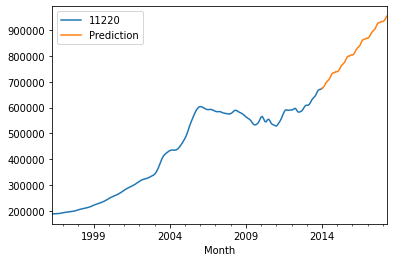

In [77]:
future_forecast = pd.DataFrame(future_forecast,index = test_brk.index,columns=['Prediction'])
pd.concat([train_brk[11220],future_forecast],axis=1).plot()

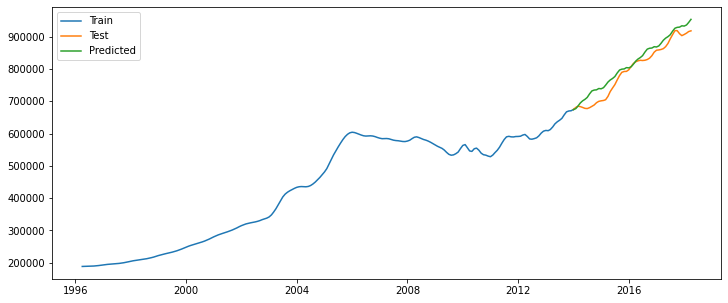

In [78]:
plt.figure(figsize=(12,5))
plt.plot(train_brk[11220], label='Train')
plt.plot(test_brk[11220],label='Test')
plt.plot(future_forecast,label='Predicted')
plt.legend()

In [79]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_brk[11220], future_forecast)
rmse = sqrt(mse)
print(rmse)

25602.845728073124


In [80]:
test_brk[11220].describe()

count        52.000000
mean     795375.000000
std       84715.836136
min      674600.000000
25%      702025.000000
50%      812050.000000
75%      860750.000000
max      918500.000000
Name: 11220, dtype: float64

In [83]:
"""
arima_dic_2 = {}
for col in df_zip.columns:
    stepwise_fit = auto_arima(df_zip[col],start_p = 1, start_q = 1,max_p = 3, max_q = 3, m = 12,trace = True, stepwise = True)
    best_AIC = stepwise_fit.aic() #extracting the best
    arima_dic_2[col] = best_AIC  #using the dictionary to set best AIC for each zipcode
output = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode','Best AIC'])
output
"""
arima_dic_2 = {}
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  best_AIC = zip_test_2.aic() #extracting the best
  arima_dic_2[col] = best_AIC

output = pd.DataFrame(arima_dic_2.items(), columns =['Zipcode','Best AIC'])
output  
   


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=1.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=2.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=1.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=4.78 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=4.50 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.52 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2593.046
Date:                            Wed, 11 Nov 2020   AIC                           5194.092
Time:                                    15:38:27   BIC                           5208.210
Sample:                                         0   HQIC                          5199.773
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4924.283, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4903.177, Time=1.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4905.170, Time=1.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4904.292, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5009.782, Time=2.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4902.792, Time=1.76 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5005.263, Time=2.41 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.93 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4926.793, Time=0.39 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4899.299, Time=2.26 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=4901.239, Time=0.77 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.43 sec
 ARIMA(2,1,0)(0,1,2)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2436.931
Date:                            Wed, 11 Nov 2020   AIC                           4885.863
Time:                                    15:41:36   BIC                           4907.039
Sample:                                         0   HQIC                          4894.384
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0412      0.035     30.015      0.000       0.973       1.109
ar.L2         -0.0720      0.015     -4.930      0.000      -0.101      -0.043
ma.L1         -0.9094      0.027    -33.969      0.000      -0.962      -0.857
ma.S.L12      -0.1413      0.016     -8.942      0.000      -0.172      -0.110
ma.S.L24      -0.0753      0.008     -8.924      0.000      -0.092      -0.059
sigma2      1.436e+07   6.39e-10   2.25e+16      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (Q):                      218.74   Jarque-Bera (JB):                23.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5184.121, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5328.856, Time=0.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5153.726, Time=0.78 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5173.771, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5148.405, Time=2.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5180.157, Time=1.53 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5141.813, Time=9.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5119.264, Time=4.21 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5132.429, Time=1.38 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5120.238, Time=2.78 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=11.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2550.400
Date:                            Wed, 11 Nov 2020   AIC                           5112.801
Time:                                    15:44:17   BIC                           5133.977
Sample:                                         0   HQIC                          5121.322
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    391.9607    174.373      2.248      0.025      50.196     733.725
ar.L1          0.6400      0.057     11.154      0.000       0.528       0.752
ma.L1         -0.4475      0.058     -7.736      0.000      -0.561      -0.334
ma.S.L12      -0.1871      0.017    -10.852      0.000      -0.221      -0.153
ma.S.L24      -0.0727      0.011     -6.496      0.000      -0.095      -0.051
sigma2      3.511e+07      0.001   2.98e+10      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (Q):                      296.81   Jarque-Bera (JB):               181.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.79
Prob(H) (two-sided):                  0.62   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5190.872, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5251.555, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5207.433, Time=0.83 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5187.411, Time=0.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5179.811, Time=0.92 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5235.500, Time=2.18 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5198.229, Time=1.26 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5321.173, Time=2.65 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5180.119, Time=1.12 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 18.155 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2586.905
Date:                            Wed, 11 Nov 2020   AIC                           5179.811
Time:                                    15:44:35   BIC                           5190.399
Sample:                                         0   HQIC                          5184.071
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1455      0.013    -11.042      0.000      -0.171      -0.120
ar.S.L24      -0.0754      0.010     -7.620      0.000      -0.095      -0.056
sigma2      4.174e+07   5.44e-12   7.67e+18      0.000    4.17e+07    4.17e+07
===================================================================================
Ljung-Box (Q):                      391.16   Jarque-Bera (JB):                38.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+35. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.68 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4862.510, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4795.191, Time=1.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4807.386, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4810.643, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4794.595, Time=6.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4851.329, Time=1.00 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4773.837, Time=7.93 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4775.437, Time=2.95 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.52 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4769.377, Time=8.30 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2378.688
Date:                            Wed, 11 Nov 2020   AIC                           4769.377
Time:                                    15:46:26   BIC                           4790.553
Sample:                                         0   HQIC                          4777.898
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1981      0.006     35.869      0.000       0.187       0.209
ar.L2          0.1238      0.008     15.631      0.000       0.108       0.139
ar.L3          0.0715      0.013      5.478      0.000       0.046       0.097
ar.S.L12      -0.1488      0.015     -9.887      0.000      -0.178      -0.119
ar.S.L24      -0.0515      0.015     -3.323      0.001      -0.082      -0.021
sigma2       8.59e+06   6.13e-11    1.4e+17      0.000    8.59e+06    8.59e+06
===================================================================================
Ljung-Box (Q):                      455.85   Jarque-Bera (JB):               372.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.87
Prob(H) (two-sided):                  0.64   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5065.172, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5014.850, Time=1.78 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5058.465, Time=0.97 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5029.881, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5007.198, Time=5.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.75 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5053.780, Time=1.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5000.580, Time=7.60 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5008.061, Time=2.71 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.22 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.53 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5001.116, Time=8.00 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2494.154
Date:                            Wed, 11 Nov 2020   AIC                           4998.307
Time:                                    15:48:34   BIC                           5015.954
Sample:                                         0   HQIC                          5005.408
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6192      0.064      9.605      0.000       0.493       0.746
ma.L1         -0.4546      0.065     -6.956      0.000      -0.583      -0.326
ar.S.L12      -0.1714      0.012    -14.868      0.000      -0.194      -0.149
ar.S.L24      -0.0761      0.010     -7.781      0.000      -0.095      -0.057
sigma2       2.26e+07   4.11e-10    5.5e+16      0.000    2.26e+07    2.26e+07
===================================================================================
Ljung-Box (Q):                      250.08   Jarque-Bera (JB):               213.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5129.825, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5091.808, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5064.512, Time=1.73 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5077.876, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5094.781, Time=1.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5067.112, Time=1.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5126.260, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5036.746, Time=4.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5063.806, Time=0.86 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5032.336, Time=9.14 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=10.71 sec
 ARIMA(1,1,0)(0,1,2)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2511.168
Date:                            Wed, 11 Nov 2020   AIC                           5032.336
Time:                                    15:50:21   BIC                           5049.984
Sample:                                         0   HQIC                          5039.437
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7343      0.049     14.878      0.000       0.638       0.831
ma.L1         -0.4285      0.049     -8.692      0.000      -0.525      -0.332
ma.S.L12      -0.3498      0.022    -15.612      0.000      -0.394      -0.306
ma.S.L24      -0.1113      0.015     -7.636      0.000      -0.140      -0.083
sigma2      2.665e+07   4.64e-10   5.75e+16      0.000    2.66e+07    2.66e+07
===================================================================================
Ljung-Box (Q):                      177.11   Jarque-Bera (JB):               369.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4847.422, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4826.980, Time=1.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4882.985, Time=0.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4828.335, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4824.801, Time=5.87 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.75 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4844.675, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4820.058, Time=7.59 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4822.417, Time=2.67 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.62 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4820.188, Time=8.36 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.029
Date:                            Wed, 11 Nov 2020   AIC                           4820.058
Time:                                    15:52:04   BIC                           4837.705
Sample:                                         0   HQIC                          4827.158
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0976      0.005     18.551      0.000       0.087       0.108
ar.L2          0.0553      0.009      6.136      0.000       0.038       0.073
ar.S.L12      -0.0740      0.017     -4.344      0.000      -0.107      -0.041
ar.S.L24      -0.0412      0.012     -3.482      0.000      -0.064      -0.018
sigma2      1.108e+07    3.5e-11   3.17e+17      0.000    1.11e+07    1.11e+07
===================================================================================
Ljung-Box (Q):                      276.43   Jarque-Bera (JB):                25.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4782.322, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4765.197, Time=1.63 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4766.470, Time=1.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4766.673, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4762.711, Time=4.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4778.975, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4759.883, Time=7.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4762.518, Time=2.67 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.28 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.64 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4760.680, Time=7.66 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2374.942
Date:                            Wed, 11 Nov 2020   AIC                           4759.883
Time:                                    15:53:45   BIC                           4777.531
Sample:                                         0   HQIC                          4766.984
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0872      0.005     16.396      0.000       0.077       0.098
ar.L2          0.0456      0.010      4.621      0.000       0.026       0.065
ar.S.L12      -0.0730      0.016     -4.610      0.000      -0.104      -0.042
ar.S.L24      -0.0418      0.011     -3.798      0.000      -0.063      -0.020
sigma2       8.71e+06   5.87e-11   1.48e+17      0.000    8.71e+06    8.71e+06
===================================================================================
Ljung-Box (Q):                      299.47   Jarque-Bera (JB):                37.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.60
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5632.039, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5496.697, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5505.900, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5552.635, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5471.450, Time=1.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5454.971, Time=4.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5453.002, Time=1.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5470.804, Time=0.68 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5454.966, Time=4.37 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=4.96 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.91 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.65 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2722.501
Date:                            Wed, 11 Nov 2020   AIC                           5453.002
Time:                                    15:54:26   BIC                           5467.120
Sample:                                         0   HQIC                          5458.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5138      0.012     43.530      0.000       0.491       0.537
ar.S.L12       0.4223      0.026     16.172      0.000       0.371       0.473
ma.S.L12      -0.8844      0.036    -24.783      0.000      -0.954      -0.814
sigma2      1.003e+08   2.31e-11   4.34e+18      0.000       1e+08       1e+08
===================================================================================
Ljung-Box (Q):                       98.22   Jarque-Bera (JB):               545.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5327.451, Time=1.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5576.658, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5356.960, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5360.031, Time=0.68 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5325.560, Time=1.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5469.850, Time=0.22 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5327.450, Time=2.79 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5359.980, Time=0.96 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=6.67 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5328.885, Time=0.59 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5327.950, Time=1.23 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=5328.369, Time=1.46 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5486.420, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=5332.419, Time=0.83 sec
 ARIMA(2,1,0)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2657.505
Date:                            Wed, 11 Nov 2020   AIC                           5325.010
Time:                                    15:55:41   BIC                           5342.657
Sample:                                         0   HQIC                          5332.111
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    320.5835    209.151      1.533      0.125     -89.345     730.512
ar.L1          0.5356      0.064      8.312      0.000       0.409       0.662
ma.L1          0.0557      0.064      0.874      0.382      -0.069       0.181
ma.S.L12      -0.7134      0.036    -19.942      0.000      -0.784      -0.643
sigma2      7.996e+07      0.001    7.4e+10      0.000       8e+07       8e+07
===================================================================================
Ljung-Box (Q):                       98.50   Jarque-Bera (JB):               267.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5067.625, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5030.213, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5077.160, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5047.671, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5010.732, Time=4.41 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5063.174, Time=1.94 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5062.240, Time=1.76 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5087.348, Time=3.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5017.695, Time=3.95 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5090.209, Time=2.24 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=5011.723, Time=4.97 sec

Best model:  ARIMA(1,1,0)(2,1,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2501.366
Date:                            Wed, 11 Nov 2020   AIC                           5010.732
Time:                                    15:56:18   BIC                           5024.850
Sample:                                         0   HQIC                          5016.413
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.010     29.946      0.000       0.281       0.321
ar.S.L12      -0.1976      0.022     -8.850      0.000      -0.241      -0.154
ar.S.L24      -0.0793      0.021     -3.724      0.000      -0.121      -0.038
sigma2      2.401e+07   1.08e-10   2.21e+17      0.000     2.4e+07     2.4e+07
===================================================================================
Ljung-Box (Q):                      162.04   Jarque-Bera (JB):               541.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.42e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4878.002, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4841.924, Time=1.95 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4862.141, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4848.529, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4838.425, Time=5.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4870.436, Time=0.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4826.653, Time=8.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4830.428, Time=2.92 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.00 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4822.351, Time=8.47 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.175
Date:                            Wed, 11 Nov 2020   AIC                           4822.351
Time:                                    15:58:13   BIC                           4843.528
Sample:                                         0   HQIC                          4830.872
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1317      0.005     24.895      0.000       0.121       0.142
ar.L2          0.0839      0.008     10.419      0.000       0.068       0.100
ar.L3          0.0608      0.010      5.792      0.000       0.040       0.081
ar.S.L12      -0.1137      0.013     -8.859      0.000      -0.139      -0.089
ar.S.L24      -0.0542      0.011     -4.999      0.000      -0.076      -0.033
sigma2       1.09e+07   2.79e-11   3.91e+17      0.000    1.09e+07    1.09e+07
===================================================================================
Ljung-Box (Q):                      364.26   Jarque-Bera (JB):                94.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.77
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5442.108, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5316.986, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5298.188, Time=0.58 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5377.311, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5286.925, Time=1.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5324.662, Time=0.41 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5288.925, Time=3.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5288.925, Time=4.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5288.877, Time=2.56 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5305.187, Time=1.13 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5290.924, Time=3.48 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(1,1,0)(1,1,1)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2632.706
Date:                            Wed, 11 Nov 2020   AIC                           5273.411
Time:                                    15:59:12   BIC                           5287.529
Sample:                                         0   HQIC                          5279.092
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4631      0.009     54.365      0.000       0.446       0.480
ar.S.L12       0.3205      0.019     17.182      0.000       0.284       0.357
ma.S.L12      -0.8026      0.030    -27.096      0.000      -0.861      -0.745
sigma2       4.34e+07   1.73e-10   2.51e+17      0.000    4.34e+07    4.34e+07
===================================================================================
Ljung-Box (Q):                      191.19   Jarque-Bera (JB):               774.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.94e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5138.306, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5099.422, Time=1.79 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5103.547, Time=1.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5105.227, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5094.185, Time=5.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5130.736, Time=0.84 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5089.127, Time=7.77 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5094.955, Time=2.85 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.44 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5089.343, Time=8.17 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2539.563
Date:                            Wed, 11 Nov 2020   AIC                           5089.127
Time:                                    16:00:54   BIC                           5106.774
Sample:                                         0   HQIC                          5096.228
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1810      0.007     27.172      0.000       0.168       0.194
ar.L2          0.0795      0.013      5.937      0.000       0.053       0.106
ar.S.L12      -0.1438      0.016     -9.119      0.000      -0.175      -0.113
ar.S.L24      -0.0734      0.012     -5.983      0.000      -0.097      -0.049
sigma2      3.267e+07   1.34e-11   2.43e+18      0.000    3.27e+07    3.27e+07
===================================================================================
Ljung-Box (Q):                      219.95   Jarque-Bera (JB):               348.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5027.532, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4939.756, Time=1.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4951.003, Time=1.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4958.915, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4925.407, Time=5.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4998.015, Time=0.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4913.691, Time=8.27 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4928.488, Time=3.40 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.29 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=7.01 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4914.827, Time=7.55 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2451.845
Date:                            Wed, 11 Nov 2020   AIC                           4913.691
Time:                                    16:02:40   BIC                           4931.338
Sample:                                         0   HQIC                          4920.792
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2831      0.007     39.195      0.000       0.269       0.297
ar.L2          0.1285      0.013      9.565      0.000       0.102       0.155
ar.S.L12      -0.2366      0.012    -19.284      0.000      -0.261      -0.213
ar.S.L24      -0.1233      0.010    -12.614      0.000      -0.143      -0.104
sigma2      1.585e+07   7.33e-11   2.16e+17      0.000    1.59e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      175.38   Jarque-Bera (JB):               623.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.84
Prob(H) (two-sided):                  0.35   Kurtosis:                        10.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4973.768, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4943.409, Time=1.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4987.651, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4950.233, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4939.514, Time=5.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.83 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4966.205, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4933.348, Time=7.79 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4937.526, Time=3.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.69 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4932.885, Time=8.60 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2460.443
Date:                            Wed, 11 Nov 2020   AIC                           4932.885
Time:                                    16:04:33   BIC                           4954.062
Sample:                                         0   HQIC                          4941.407
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1163      0.006     21.024      0.000       0.105       0.127
ar.L2          0.0636      0.010      6.668      0.000       0.045       0.082
ar.L3          0.0367      0.015      2.390      0.017       0.007       0.067
ar.S.L12      -0.1136      0.013     -9.045      0.000      -0.138      -0.089
ar.S.L24      -0.0539      0.010     -5.340      0.000      -0.074      -0.034
sigma2      1.726e+07   2.19e-11    7.9e+17      0.000    1.73e+07    1.73e+07
===================================================================================
Ljung-Box (Q):                      337.70   Jarque-Bera (JB):                31.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.41
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5307.778, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5230.085, Time=1.87 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5266.294, Time=1.00 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5249.734, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.999, Time=1.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5222.048, Time=1.69 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5209.512, Time=4.99 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.77 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5262.204, Time=3.30 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=5203.031, Time=6.46 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5215.319, Time=2.77 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=9.19 sec
 ARIMA(2,1,0)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 12)   Log Likelihood               -2596.515
Date:                            Wed, 11 Nov 2020   AIC                           5203.031
Time:                                    16:06:16   BIC                           5220.678
Sample:                                         0   HQIC                          5210.132
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.009     29.382      0.000       0.251       0.287
ar.L2          0.1047      0.019      5.509      0.000       0.067       0.142
ma.S.L12      -0.3357      0.021    -16.248      0.000      -0.376      -0.295
ma.S.L24      -0.1465      0.012    -11.944      0.000      -0.171      -0.122
sigma2      5.141e+07   3.21e-11    1.6e+18      0.000    5.14e+07    5.14e+07
===================================================================================
Ljung-Box (Q):                      161.48   Jarque-Bera (JB):               401.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.60
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4798.502, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4773.764, Time=1.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4811.280, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4775.721, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4771.602, Time=4.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4795.656, Time=1.70 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4766.701, Time=7.15 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4769.087, Time=2.61 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.41 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4766.633, Time=7.82 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2377.316
Date:                            Wed, 11 Nov 2020   AIC                           4766.633
Time:                                    16:08:00   BIC                           4787.809
Sample:                                         0   HQIC                          4775.154
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1185      0.006     21.124      0.000       0.107       0.129
ar.L2          0.0592      0.010      5.686      0.000       0.039       0.080
ar.L3          0.0344      0.017      2.038      0.042       0.001       0.067
ar.S.L12      -0.0884      0.016     -5.412      0.000      -0.120      -0.056
ar.S.L24      -0.0474      0.012     -3.816      0.000      -0.072      -0.023
sigma2      8.802e+06   5.69e-11   1.55e+17      0.000     8.8e+06     8.8e+06
===================================================================================
Ljung-Box (Q):                      244.65   Jarque-Bera (JB):                45.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.37e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5192.097, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5112.446, Time=1.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5142.891, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5141.183, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5106.730, Time=4.65 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5091.082, Time=3.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5105.256, Time=1.60 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.45 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5166.462, Time=2.37 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=10.25 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2541.541
Date:                            Wed, 11 Nov 2020   AIC                           5091.082
Time:                                    16:09:03   BIC                           5105.200
Sample:                                         0   HQIC                          5096.763
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2365      0.009     27.622      0.000       0.220       0.253
ar.S.L12       0.4904      0.028     17.294      0.000       0.435       0.546
ma.S.L12      -0.8364      0.042    -19.903      0.000      -0.919      -0.754
sigma2      3.287e+07   1.16e-10   2.84e+17      0.000    3.29e+07    3.29e+07
===================================================================================
Ljung-Box (Q):                      302.61   Jarque-Bera (JB):               122.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.38
Prob(H) (two-sided):                  0.34   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5336.633, Time=1.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5488.053, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5306.605, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5327.220, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5386.104, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.581, Time=1.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5292.136, Time=4.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5291.520, Time=0.91 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5290.423, Time=0.50 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5291.777, Time=1.83 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5428.023, Time=1.00 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5290.917, Time=2.00 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5291.359, Time=2.12 sec
 ARIMA(2,1,1)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2642.211
Date:                            Wed, 11 Nov 2020   AIC                           5290.423
Time:                                    16:09:33   BIC                           5301.011
Sample:                                         0   HQIC                          5294.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5829      0.017     34.629      0.000       0.550       0.616
ma.S.L12      -0.5311      0.023    -22.849      0.000      -0.577      -0.486
sigma2      7.161e+07   8.33e-11    8.6e+17      0.000    7.16e+07    7.16e+07
===================================================================================
Ljung-Box (Q):                      196.17   Jarque-Bera (JB):               738.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.34e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5205.476, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5250.270, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5122.008, Time=1.75 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5174.319, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5107.396, Time=1.79 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5135.197, Time=0.49 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=4.24 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.71 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5116.759, Time=2.96 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5128.399, Time=1.48 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=6.32 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.92 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2549.698
Date:                            Wed, 11 Nov 2020   AIC                           5107.396
Time:                                    16:10:20   BIC                           5121.514
Sample:                                         0   HQIC                          5113.077
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2039      0.009     23.134      0.000       0.187       0.221
ar.S.L12       0.4981      0.026     19.472      0.000       0.448       0.548
ma.S.L12      -0.8689      0.029    -30.243      0.000      -0.925      -0.813
sigma2      3.194e+07   1.21e-10   2.65e+17      0.000    3.19e+07    3.19e+07
===================================================================================
Ljung-Box (Q):                      401.23   Jarque-Bera (JB):                36.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5072.072, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5067.249, Time=0.68 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5068.640, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5106.489, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5038.387, Time=1.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5046.370, Time=0.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4992.113, Time=6.93 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5007.508, Time=2.51 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.62 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.24 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4993.543, Time=6.85 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2490.468
Date:                            Wed, 11 Nov 2020   AIC                           4990.937
Time:                                    16:12:29   BIC                           5008.584
Sample:                                         0   HQIC                          4998.038
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5670      0.070      8.148      0.000       0.431       0.703
ma.L1         -0.3597      0.071     -5.084      0.000      -0.498      -0.221
ar.S.L12      -0.2317      0.011    -21.212      0.000      -0.253      -0.210
ar.S.L24      -0.1178      0.009    -13.549      0.000      -0.135      -0.101
sigma2      2.195e+07   2.57e-09   8.53e+15      0.000    2.19e+07    2.19e+07
===================================================================================
Ljung-Box (Q):                      257.27   Jarque-Bera (JB):               654.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5373.413, Time=1.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5601.593, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5399.493, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5395.274, Time=0.69 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5374.275, Time=1.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5416.978, Time=0.86 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=5375.377, Time=4.81 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5375.384, Time=7.93 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5537.241, Time=0.30 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5373.555, Time=3.85 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5393.306, Time=2.91 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=12.20 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5394.489, Time=0.98 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5371.021, Time=0.86 sec
 ARIMA(1,1,0)(0,1,1)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2682.089
Date:                            Wed, 11 Nov 2020   AIC                           5370.177
Time:                                    16:13:18   BIC                           5380.766
Sample:                                         0   HQIC                          5374.438
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5782      0.027     21.575      0.000       0.526       0.631
ma.S.L12      -0.6883      0.038    -18.353      0.000      -0.762      -0.615
sigma2      1.211e+08   3.94e-11   3.07e+18      0.000    1.21e+08    1.21e+08
===================================================================================
Ljung-Box (Q):                      162.10   Jarque-Bera (JB):               330.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=13.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5013.844, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4987.586, Time=1.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4988.989, Time=1.92 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4993.126, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4982.754, Time=5.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5006.315, Time=1.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4979.431, Time=7.59 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4984.404, Time=2.82 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.89 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.31 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4980.714, Time=9.97 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2484.716
Date:                            Wed, 11 Nov 2020   AIC                           4979.431
Time:                                    16:15:15   BIC                           4997.078
Sample:                                         0   HQIC                          4986.532
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1111      0.006     19.834      0.000       0.100       0.122
ar.L2          0.0541      0.011      5.085      0.000       0.033       0.075
ar.S.L12      -0.1105      0.013     -8.683      0.000      -0.135      -0.086
ar.S.L24      -0.0562      0.009     -5.965      0.000      -0.075      -0.038
sigma2      2.107e+07   1.16e-11   1.81e+18      0.000    2.11e+07    2.11e+07
===================================================================================
Ljung-Box (Q):                      370.66   Jarque-Bera (JB):                79.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.74e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.78 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.71 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=2.07 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.26 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.65 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=2.38 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=3.63 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 2, 12)   Log Likelihood               -2795.831
Date:                            Wed, 11 Nov 2020   AIC                           5603.661
Time:                                    16:17:19   BIC                           5624.838
Sample:                                         0   HQIC                          5612.182
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5850.231, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5851.087, Time=0.68 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5901.628, Time=0.87 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5845.323, Time=0.57 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5838.438, Time=1.02 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5837.560, Time=1.18 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5870.745, Time=2.33 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5918.840, Time=3.54 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5889.355, Time=1.24 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2914.780
Date:                            Wed, 11 Nov 2020   AIC                           5837.560
Time:                                    16:17:59   BIC                           5851.677
Sample:                                         0   HQIC                          5843.240
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1606      0.005     33.193      0.000       0.151       0.170
ar.S.L12      -0.1651      0.009    -18.987      0.000      -0.182      -0.148
ar.S.L24      -0.0837      0.006    -13.184      0.000      -0.096      -0.071
sigma2       3.78e+08   1.02e-12   3.71e+20      0.000    3.78e+08    3.78e+08
===================================================================================
Ljung-Box (Q):                      160.92   Jarque-Bera (JB):               341.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+36. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5621.912, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5683.611, Time=1.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5771.778, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5623.719, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5626.495, Time=0.29 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5681.968, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5770.253, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5841.795, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=5622.047, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 10.415 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2809.956
Date:                            Wed, 11 Nov 2020   AIC                           5621.912
Time:                                    16:18:09   BIC                           5625.441
Sample:                                         0   HQIC                          5623.332
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.694e+08   1.52e+07     17.697      0.000     2.4e+08    2.99e+08
===================================================================================
Ljung-Box (Q):                      275.35   Jarque-Bera (JB):                66.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             678.20   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Zipcode,Best AIC
0,11226,5194.092117
1,11235,4885.862508
2,11230,5112.800921
3,11209,5179.810932
4,11212,4769.376866
5,11214,4998.307087
6,11221,5032.336423
7,11229,4820.057594
8,11234,4759.883401
9,11215,5453.002002


In [45]:
arima_dic_2 = {}
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  arima_dic_2[col] = zip_test_2
  
pd.DataFrame(arima_dic_2.items())    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.65 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=1.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=2.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=1.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=5.29 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=4.71 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.65 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.30 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2593.046
Date:                            Wed, 11 Nov 2020   AIC                           5194.092
Time:                                    02:54:47   BIC                           5208.210
Sample:                                         0   HQIC                          5199.773
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4924.283, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4903.177, Time=1.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4905.170, Time=1.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4904.292, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5009.782, Time=2.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4902.792, Time=1.83 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5005.263, Time=2.42 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.99 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4926.793, Time=0.40 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4899.299, Time=2.30 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=4901.239, Time=0.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(2,1,0)(0,1,2)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2436.931
Date:                            Wed, 11 Nov 2020   AIC                           4885.863
Time:                                    02:57:55   BIC                           4907.039
Sample:                                         0   HQIC                          4894.384
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0412      0.035     30.015      0.000       0.973       1.109
ar.L2         -0.0720      0.015     -4.930      0.000      -0.101      -0.043
ma.L1         -0.9094      0.027    -33.969      0.000      -0.962      -0.857
ma.S.L12      -0.1413      0.016     -8.942      0.000      -0.172      -0.110
ma.S.L24      -0.0753      0.008     -8.924      0.000      -0.092      -0.059
sigma2      1.436e+07   6.39e-10   2.25e+16      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (Q):                      218.74   Jarque-Bera (JB):                23.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5184.121, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5328.856, Time=0.87 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5153.726, Time=0.77 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5173.771, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=3.72 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5148.405, Time=2.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5180.157, Time=1.57 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5141.813, Time=9.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5119.264, Time=4.25 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5132.429, Time=1.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5120.238, Time=2.80 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=12.68 sec
 ARIMA(1,1,0)(0,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2550.400
Date:                            Wed, 11 Nov 2020   AIC                           5112.801
Time:                                    03:00:40   BIC                           5133.977
Sample:                                         0   HQIC                          5121.322
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    391.9607    174.373      2.248      0.025      50.196     733.725
ar.L1          0.6400      0.057     11.154      0.000       0.528       0.752
ma.L1         -0.4475      0.058     -7.736      0.000      -0.561      -0.334
ma.S.L12      -0.1871      0.017    -10.852      0.000      -0.221      -0.153
ma.S.L24      -0.0727      0.011     -6.496      0.000      -0.095      -0.051
sigma2      3.511e+07      0.001   2.98e+10      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (Q):                      296.81   Jarque-Bera (JB):               181.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.79
Prob(H) (two-sided):                  0.62   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5190.872, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5251.555, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5207.433, Time=0.84 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5187.411, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5179.811, Time=0.94 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5235.500, Time=2.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5198.229, Time=1.27 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5321.173, Time=2.64 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5180.119, Time=1.18 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 18.524 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2586.905
Date:                            Wed, 11 Nov 2020   AIC                           5179.811
Time:                                    03:00:58   BIC                           5190.399
Sample:                                         0   HQIC                          5184.071
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1455      0.013    -11.042      0.000      -0.171      -0.120
ar.S.L24      -0.0754      0.010     -7.620      0.000      -0.095      -0.056
sigma2      4.174e+07   5.44e-12   7.67e+18      0.000    4.17e+07    4.17e+07
===================================================================================
Ljung-Box (Q):                      391.16   Jarque-Bera (JB):                38.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+35. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4862.510, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4795.191, Time=1.90 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4807.386, Time=0.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4810.643, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4794.595, Time=6.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.55 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4851.329, Time=1.02 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4773.837, Time=8.09 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4775.437, Time=3.03 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.17 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.70 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4769.377, Time=8.50 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2378.688
Date:                            Wed, 11 Nov 2020   AIC                           4769.377
Time:                                    03:02:52   BIC                           4790.553
Sample:                                         0   HQIC                          4777.898
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1981      0.006     35.869      0.000       0.187       0.209
ar.L2          0.1238      0.008     15.631      0.000       0.108       0.139
ar.L3          0.0715      0.013      5.478      0.000       0.046       0.097
ar.S.L12      -0.1488      0.015     -9.887      0.000      -0.178      -0.119
ar.S.L24      -0.0515      0.015     -3.323      0.001      -0.082      -0.021
sigma2       8.59e+06   6.13e-11    1.4e+17      0.000    8.59e+06    8.59e+06
===================================================================================
Ljung-Box (Q):                      455.85   Jarque-Bera (JB):               372.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.87
Prob(H) (two-sided):                  0.64   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5065.172, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5014.850, Time=1.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5058.465, Time=1.00 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5029.881, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5007.198, Time=5.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.11 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5053.780, Time=1.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5000.580, Time=7.63 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5008.061, Time=2.75 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.32 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.58 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5001.116, Time=8.12 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2494.154
Date:                            Wed, 11 Nov 2020   AIC                           4998.307
Time:                                    03:05:02   BIC                           5015.954
Sample:                                         0   HQIC                          5005.408
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6192      0.064      9.605      0.000       0.493       0.746
ma.L1         -0.4546      0.065     -6.956      0.000      -0.583      -0.326
ar.S.L12      -0.1714      0.012    -14.868      0.000      -0.194      -0.149
ar.S.L24      -0.0761      0.010     -7.781      0.000      -0.095      -0.057
sigma2       2.26e+07   4.11e-10    5.5e+16      0.000    2.26e+07    2.26e+07
===================================================================================
Ljung-Box (Q):                      250.08   Jarque-Bera (JB):               213.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5129.825, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5091.808, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5064.512, Time=1.74 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5077.876, Time=0.43 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.96 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5094.781, Time=1.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5067.112, Time=1.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5126.260, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5036.746, Time=4.13 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5063.806, Time=0.86 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5032.336, Time=9.25 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=10.83 sec
 ARIMA(1,1,0)(0,1,2)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2511.168
Date:                            Wed, 11 Nov 2020   AIC                           5032.336
Time:                                    03:06:51   BIC                           5049.984
Sample:                                         0   HQIC                          5039.437
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7343      0.049     14.878      0.000       0.638       0.831
ma.L1         -0.4285      0.049     -8.692      0.000      -0.525      -0.332
ma.S.L12      -0.3498      0.022    -15.612      0.000      -0.394      -0.306
ma.S.L24      -0.1113      0.015     -7.636      0.000      -0.140      -0.083
sigma2      2.665e+07   4.64e-10   5.75e+16      0.000    2.66e+07    2.66e+07
===================================================================================
Ljung-Box (Q):                      177.11   Jarque-Bera (JB):               369.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=6.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4847.422, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4826.980, Time=2.02 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4882.985, Time=0.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4828.335, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4824.801, Time=5.95 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4844.675, Time=0.93 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4820.058, Time=7.69 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4822.417, Time=2.78 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4820.188, Time=8.41 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.029
Date:                            Wed, 11 Nov 2020   AIC                           4820.058
Time:                                    03:08:36   BIC                           4837.705
Sample:                                         0   HQIC                          4827.158
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0976      0.005     18.551      0.000       0.087       0.108
ar.L2          0.0553      0.009      6.136      0.000       0.038       0.073
ar.S.L12      -0.0740      0.017     -4.344      0.000      -0.107      -0.041
ar.S.L24      -0.0412      0.012     -3.482      0.000      -0.064      -0.018
sigma2      1.108e+07    3.5e-11   3.17e+17      0.000    1.11e+07    1.11e+07
===================================================================================
Ljung-Box (Q):                      276.43   Jarque-Bera (JB):                25.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.71 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4782.322, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4765.197, Time=1.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4766.470, Time=1.75 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4766.673, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4762.711, Time=5.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4778.975, Time=0.94 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4759.883, Time=7.23 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4762.518, Time=2.76 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.73 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4760.680, Time=7.79 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2374.942
Date:                            Wed, 11 Nov 2020   AIC                           4759.883
Time:                                    03:10:18   BIC                           4777.531
Sample:                                         0   HQIC                          4766.984
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0872      0.005     16.396      0.000       0.077       0.098
ar.L2          0.0456      0.010      4.621      0.000       0.026       0.065
ar.S.L12      -0.0730      0.016     -4.610      0.000      -0.104      -0.042
ar.S.L24      -0.0418      0.011     -3.798      0.000      -0.063      -0.020
sigma2       8.71e+06   5.87e-11   1.48e+17      0.000    8.71e+06    8.71e+06
===================================================================================
Ljung-Box (Q):                      299.47   Jarque-Bera (JB):                37.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.60
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5632.039, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5496.697, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5505.900, Time=0.62 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5552.635, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5471.450, Time=1.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5454.971, Time=4.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5453.002, Time=1.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5470.804, Time=0.69 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5454.966, Time=4.37 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=4.96 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.93 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.73 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2722.501
Date:                            Wed, 11 Nov 2020   AIC                           5453.002
Time:                                    03:11:00   BIC                           5467.120
Sample:                                         0   HQIC                          5458.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5138      0.012     43.530      0.000       0.491       0.537
ar.S.L12       0.4223      0.026     16.172      0.000       0.371       0.473
ma.S.L12      -0.8844      0.036    -24.783      0.000      -0.954      -0.814
sigma2      1.003e+08   2.31e-11   4.34e+18      0.000       1e+08       1e+08
===================================================================================
Ljung-Box (Q):                       98.22   Jarque-Bera (JB):               545.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5327.451, Time=1.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5576.658, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5356.960, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5360.031, Time=0.71 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5325.560, Time=1.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5469.850, Time=0.24 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5327.450, Time=2.85 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5359.980, Time=0.96 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=6.72 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5328.885, Time=0.61 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5327.950, Time=1.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=5328.369, Time=1.48 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5486.420, Time=0.31 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=5332.419, Time=0.85 sec
 ARIMA(2,1,0)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2657.505
Date:                            Wed, 11 Nov 2020   AIC                           5325.010
Time:                                    03:12:16   BIC                           5342.657
Sample:                                         0   HQIC                          5332.111
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    320.5835    209.151      1.533      0.125     -89.345     730.512
ar.L1          0.5356      0.064      8.312      0.000       0.409       0.662
ma.L1          0.0557      0.064      0.874      0.382      -0.069       0.181
ma.S.L12      -0.7134      0.036    -19.942      0.000      -0.784      -0.643
sigma2      7.996e+07      0.001    7.4e+10      0.000       8e+07       8e+07
===================================================================================
Ljung-Box (Q):                       98.50   Jarque-Bera (JB):               267.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5067.625, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5030.213, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5077.160, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5047.671, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5010.732, Time=4.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5063.174, Time=1.97 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5062.240, Time=1.80 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5087.348, Time=3.34 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5017.695, Time=3.99 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5090.209, Time=2.27 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=5011.723, Time=5.07 sec

Best model:  ARIMA(1,1,0)(2,1,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2501.366
Date:                            Wed, 11 Nov 2020   AIC                           5010.732
Time:                                    03:12:54   BIC                           5024.850
Sample:                                         0   HQIC                          5016.413
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.010     29.946      0.000       0.281       0.321
ar.S.L12      -0.1976      0.022     -8.850      0.000      -0.241      -0.154
ar.S.L24      -0.0793      0.021     -3.724      0.000      -0.121      -0.038
sigma2      2.401e+07   1.08e-10   2.21e+17      0.000     2.4e+07     2.4e+07
===================================================================================
Ljung-Box (Q):                      162.04   Jarque-Bera (JB):               541.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.42e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4878.002, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4841.924, Time=2.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4862.141, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4848.529, Time=0.32 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4838.425, Time=5.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4870.436, Time=0.84 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4826.653, Time=8.45 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4830.428, Time=2.98 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.18 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.82 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4822.351, Time=8.58 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.175
Date:                            Wed, 11 Nov 2020   AIC                           4822.351
Time:                                    03:14:50   BIC                           4843.528
Sample:                                         0   HQIC                          4830.872
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1317      0.005     24.895      0.000       0.121       0.142
ar.L2          0.0839      0.008     10.419      0.000       0.068       0.100
ar.L3          0.0608      0.010      5.792      0.000       0.040       0.081
ar.S.L12      -0.1137      0.013     -8.859      0.000      -0.139      -0.089
ar.S.L24      -0.0542      0.011     -4.999      0.000      -0.076      -0.033
sigma2       1.09e+07   2.79e-11   3.91e+17      0.000    1.09e+07    1.09e+07
===================================================================================
Ljung-Box (Q):                      364.26   Jarque-Bera (JB):                94.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.77
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5442.108, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5316.986, Time=0.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5298.188, Time=0.61 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5377.311, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5286.925, Time=1.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5324.662, Time=0.44 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5288.925, Time=3.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5288.925, Time=4.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5288.877, Time=2.61 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5305.187, Time=1.17 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5290.924, Time=3.55 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.59 sec
 ARIMA(1,1,0)(1,1,1)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2632.706
Date:                            Wed, 11 Nov 2020   AIC                           5273.411
Time:                                    03:15:51   BIC                           5287.529
Sample:                                         0   HQIC                          5279.092
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4631      0.009     54.365      0.000       0.446       0.480
ar.S.L12       0.3205      0.019     17.182      0.000       0.284       0.357
ma.S.L12      -0.8026      0.030    -27.096      0.000      -0.861      -0.745
sigma2       4.34e+07   1.73e-10   2.51e+17      0.000    4.34e+07    4.34e+07
===================================================================================
Ljung-Box (Q):                      191.19   Jarque-Bera (JB):               774.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.94e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5138.306, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5099.422, Time=1.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5103.547, Time=1.96 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5105.227, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5094.185, Time=5.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.44 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.85 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5130.736, Time=0.88 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5089.127, Time=7.94 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5094.955, Time=2.93 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.20 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.52 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5089.343, Time=8.29 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2539.563
Date:                            Wed, 11 Nov 2020   AIC                           5089.127
Time:                                    03:17:34   BIC                           5106.774
Sample:                                         0   HQIC                          5096.228
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1810      0.007     27.172      0.000       0.168       0.194
ar.L2          0.0795      0.013      5.937      0.000       0.053       0.106
ar.S.L12      -0.1438      0.016     -9.119      0.000      -0.175      -0.113
ar.S.L24      -0.0734      0.012     -5.983      0.000      -0.097      -0.049
sigma2      3.267e+07   1.34e-11   2.43e+18      0.000    3.27e+07    3.27e+07
===================================================================================
Ljung-Box (Q):                      219.95   Jarque-Bera (JB):               348.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5027.532, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4939.756, Time=1.91 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4951.003, Time=1.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4958.915, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4925.407, Time=5.50 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4998.015, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4913.691, Time=8.28 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4928.488, Time=4.56 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=13.71 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.43 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4914.827, Time=7.58 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2451.845
Date:                            Wed, 11 Nov 2020   AIC                           4913.691
Time:                                    03:19:22   BIC                           4931.338
Sample:                                         0   HQIC                          4920.792
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2831      0.007     39.195      0.000       0.269       0.297
ar.L2          0.1285      0.013      9.565      0.000       0.102       0.155
ar.S.L12      -0.2366      0.012    -19.284      0.000      -0.261      -0.213
ar.S.L24      -0.1233      0.010    -12.614      0.000      -0.143      -0.104
sigma2      1.585e+07   7.33e-11   2.16e+17      0.000    1.59e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      175.38   Jarque-Bera (JB):               623.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.84
Prob(H) (two-sided):                  0.35   Kurtosis:                        10.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4973.768, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4943.409, Time=1.90 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4987.651, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4950.233, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4939.514, Time=5.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.89 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4966.205, Time=0.94 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4933.348, Time=7.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4937.526, Time=3.56 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.82 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4932.885, Time=8.79 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2460.443
Date:                            Wed, 11 Nov 2020   AIC                           4932.885
Time:                                    03:21:18   BIC                           4954.062
Sample:                                         0   HQIC                          4941.407
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1163      0.006     21.024      0.000       0.105       0.127
ar.L2          0.0636      0.010      6.668      0.000       0.045       0.082
ar.L3          0.0367      0.015      2.390      0.017       0.007       0.067
ar.S.L12      -0.1136      0.013     -9.045      0.000      -0.138      -0.089
ar.S.L24      -0.0539      0.010     -5.340      0.000      -0.074      -0.034
sigma2      1.726e+07   2.19e-11    7.9e+17      0.000    1.73e+07    1.73e+07
===================================================================================
Ljung-Box (Q):                      337.70   Jarque-Bera (JB):                31.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.41
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5307.778, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5230.085, Time=1.92 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5266.294, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5249.734, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.999, Time=2.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5222.048, Time=1.76 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5209.512, Time=5.11 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.96 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5262.204, Time=3.41 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=5203.031, Time=6.49 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5215.319, Time=2.84 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=9.43 sec
 ARIMA(2,1,0)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 12)   Log Likelihood               -2596.515
Date:                            Wed, 11 Nov 2020   AIC                           5203.031
Time:                                    03:23:03   BIC                           5220.678
Sample:                                         0   HQIC                          5210.132
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.009     29.382      0.000       0.251       0.287
ar.L2          0.1047      0.019      5.509      0.000       0.067       0.142
ma.S.L12      -0.3357      0.021    -16.248      0.000      -0.376      -0.295
ma.S.L24      -0.1465      0.012    -11.944      0.000      -0.171      -0.122
sigma2      5.141e+07   3.21e-11    1.6e+18      0.000    5.14e+07    5.14e+07
===================================================================================
Ljung-Box (Q):                      161.48   Jarque-Bera (JB):               401.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.60
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4798.502, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4773.764, Time=1.70 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4811.280, Time=0.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4775.721, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4771.602, Time=4.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4795.656, Time=1.73 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4766.701, Time=7.31 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4769.087, Time=2.70 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.55 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4766.633, Time=7.99 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2377.316
Date:                            Wed, 11 Nov 2020   AIC                           4766.633
Time:                                    03:24:50   BIC                           4787.809
Sample:                                         0   HQIC                          4775.154
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1185      0.006     21.124      0.000       0.107       0.129
ar.L2          0.0592      0.010      5.686      0.000       0.039       0.080
ar.L3          0.0344      0.017      2.038      0.042       0.001       0.067
ar.S.L12      -0.0884      0.016     -5.412      0.000      -0.120      -0.056
ar.S.L24      -0.0474      0.012     -3.816      0.000      -0.072      -0.023
sigma2      8.802e+06   5.69e-11   1.55e+17      0.000     8.8e+06     8.8e+06
===================================================================================
Ljung-Box (Q):                      244.65   Jarque-Bera (JB):                45.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.37e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5192.097, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5112.446, Time=1.87 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5142.891, Time=0.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5141.183, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5106.730, Time=4.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5091.082, Time=3.39 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5105.256, Time=1.66 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.58 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5166.462, Time=2.43 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=10.44 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2541.541
Date:                            Wed, 11 Nov 2020   AIC                           5091.082
Time:                                    03:25:55   BIC                           5105.200
Sample:                                         0   HQIC                          5096.763
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2365      0.009     27.622      0.000       0.220       0.253
ar.S.L12       0.4904      0.028     17.294      0.000       0.435       0.546
ma.S.L12      -0.8364      0.042    -19.903      0.000      -0.919      -0.754
sigma2      3.287e+07   1.16e-10   2.84e+17      0.000    3.29e+07    3.29e+07
===================================================================================
Ljung-Box (Q):                      302.61   Jarque-Bera (JB):               122.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.38
Prob(H) (two-sided):                  0.34   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5336.633, Time=1.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5488.053, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5306.605, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5327.220, Time=0.57 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5386.104, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.581, Time=1.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5292.136, Time=4.83 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5291.520, Time=0.93 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5290.423, Time=0.55 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5291.777, Time=1.85 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5428.023, Time=1.00 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5290.917, Time=2.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5291.359, Time=2.21 sec
 ARIMA(2,1,1)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2642.211
Date:                            Wed, 11 Nov 2020   AIC                           5290.423
Time:                                    03:26:25   BIC                           5301.011
Sample:                                         0   HQIC                          5294.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5829      0.017     34.629      0.000       0.550       0.616
ma.S.L12      -0.5311      0.023    -22.849      0.000      -0.577      -0.486
sigma2      7.161e+07   8.33e-11    8.6e+17      0.000    7.16e+07    7.16e+07
===================================================================================
Ljung-Box (Q):                      196.17   Jarque-Bera (JB):               738.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.34e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5205.476, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5250.270, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5122.008, Time=1.81 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5174.319, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5107.396, Time=1.80 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5135.197, Time=0.51 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=4.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.78 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5116.759, Time=3.01 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5128.399, Time=1.51 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=6.48 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.35 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=4.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2549.698
Date:                            Wed, 11 Nov 2020   AIC                           5107.396
Time:                                    03:27:13   BIC                           5121.514
Sample:                                         0   HQIC                          5113.077
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2039      0.009     23.134      0.000       0.187       0.221
ar.S.L12       0.4981      0.026     19.472      0.000       0.448       0.548
ma.S.L12      -0.8689      0.029    -30.243      0.000      -0.925      -0.813
sigma2      3.194e+07   1.21e-10   2.65e+17      0.000    3.19e+07    3.19e+07
===================================================================================
Ljung-Box (Q):                      401.23   Jarque-Bera (JB):                36.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5072.072, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5067.249, Time=0.71 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5068.640, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5106.489, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5038.387, Time=1.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5046.370, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4992.113, Time=7.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5007.508, Time=2.58 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.77 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4993.543, Time=6.98 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2490.468
Date:                            Wed, 11 Nov 2020   AIC                           4990.937
Time:                                    03:29:26   BIC                           5008.584
Sample:                                         0   HQIC                          4998.038
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5670      0.070      8.148      0.000       0.431       0.703
ma.L1         -0.3597      0.071     -5.084      0.000      -0.498      -0.221
ar.S.L12      -0.2317      0.011    -21.212      0.000      -0.253      -0.210
ar.S.L24      -0.1178      0.009    -13.549      0.000      -0.135      -0.101
sigma2      2.195e+07   2.57e-09   8.53e+15      0.000    2.19e+07    2.19e+07
===================================================================================
Ljung-Box (Q):                      257.27   Jarque-Bera (JB):               654.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5373.413, Time=1.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5601.593, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5399.493, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5395.274, Time=0.71 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5374.275, Time=1.13 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5416.978, Time=0.90 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=5375.377, Time=4.92 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5375.384, Time=7.95 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5537.241, Time=0.32 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5373.555, Time=3.94 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5393.306, Time=2.97 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=12.42 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5394.489, Time=1.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5371.021, Time=0.91 sec
 ARIMA(1,1,0)(0,1,1)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2682.089
Date:                            Wed, 11 Nov 2020   AIC                           5370.177
Time:                                    03:30:16   BIC                           5380.766
Sample:                                         0   HQIC                          5374.438
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5782      0.027     21.575      0.000       0.526       0.631
ma.S.L12      -0.6883      0.038    -18.353      0.000      -0.762      -0.615
sigma2      1.211e+08   3.94e-11   3.07e+18      0.000    1.21e+08    1.21e+08
===================================================================================
Ljung-Box (Q):                      162.10   Jarque-Bera (JB):               330.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=14.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5013.844, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4987.586, Time=1.95 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4988.989, Time=1.99 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4993.126, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4982.754, Time=5.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5006.315, Time=1.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4979.431, Time=7.76 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4984.404, Time=2.90 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.00 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.53 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4980.714, Time=10.14 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2484.716
Date:                            Wed, 11 Nov 2020   AIC                           4979.431
Time:                                    03:32:17   BIC                           4997.078
Sample:                                         0   HQIC                          4986.532
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1111      0.006     19.834      0.000       0.100       0.122
ar.L2          0.0541      0.011      5.085      0.000       0.033       0.075
ar.S.L12      -0.1105      0.013     -8.683      0.000      -0.135      -0.086
ar.S.L24      -0.0562      0.009     -5.965      0.000      -0.075      -0.038
sigma2      2.107e+07   1.16e-11   1.81e+18      0.000    2.11e+07    2.11e+07
===================================================================================
Ljung-Box (Q):                      370.66   Jarque-Bera (JB):                79.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.74e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.85 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.83 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.78 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=2.14 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.31 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.67 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=2.44 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=3.71 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 2, 12)   Log Likelihood               -2795.831
Date:                            Wed, 11 Nov 2020   AIC                           5603.661
Time:                                    03:34:24   BIC                           5624.838
Sample:                                         0   HQIC                          5612.182
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5850.231, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5851.087, Time=0.70 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5901.628, Time=0.88 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5845.323, Time=0.59 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5838.438, Time=1.01 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.84 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5837.560, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.90 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.65 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5870.745, Time=2.40 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5918.840, Time=3.61 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5889.355, Time=1.27 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2914.780
Date:                            Wed, 11 Nov 2020   AIC                           5837.560
Time:                                    03:35:05   BIC                           5851.677
Sample:                                         0   HQIC                          5843.240
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1606      0.005     33.193      0.000       0.151       0.170
ar.S.L12      -0.1651      0.009    -18.987      0.000      -0.182      -0.148
ar.S.L24      -0.0837      0.006    -13.184      0.000      -0.096      -0.071
sigma2       3.78e+08   1.02e-12   3.71e+20      0.000    3.78e+08    3.78e+08
===================================================================================
Ljung-Box (Q):                      160.92   Jarque-Bera (JB):               341.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+36. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5621.912, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5683.611, Time=2.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5771.778, Time=0.57 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5623.719, Time=0.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5626.495, Time=0.31 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5681.968, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5770.253, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5841.795, Time=1.00 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=5622.047, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 10.679 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2809.956
Date:                            Wed, 11 Nov 2020   AIC                           5621.912
Time:                                    03:35:15   BIC                           5625.441
Sample:                                         0   HQIC                          5623.332
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.694e+08   1.52e+07     17.697      0.000     2.4e+08    2.99e+08
===================================================================================
Ljung-Box (Q):                      275.35   Jarque-Bera (JB):                66.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             678.20   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,0,1
0,11226,"ARIMA(1,1,0)(1,1,1)[12]"
1,11235,"ARIMA(2,1,1)(0,1,2)[12]"
2,11230,"ARIMA(1,1,1)(0,1,2)[12] intercept"
3,11209,"ARIMA(0,1,0)(2,1,0)[12]"
4,11212,"ARIMA(3,1,0)(2,1,0)[12]"
5,11214,"ARIMA(1,1,1)(2,1,0)[12]"
6,11221,"ARIMA(1,1,1)(0,1,2)[12]"
7,11229,"ARIMA(2,1,0)(2,1,0)[12]"
8,11234,"ARIMA(2,1,0)(2,1,0)[12]"
9,11215,"ARIMA(1,1,0)(1,1,1)[12]"


In [253]:
arima_dic = {}
for col in zip_df.columns:
  zip_test_1 = arima_model(zip_df[col])
  arima_dic[col] = zip_test_1

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.64 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=1.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=2.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=1.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=4.75 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=4.41 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.52 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2593.046
Date:                            Tue, 10 Nov 2020   AIC                           5194.092
Time:                                    21:50:28   BIC                           5208.210
Sample:                                         0   HQIC                          5199.773
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4924.283, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4903.177, Time=1.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4905.170, Time=1.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4904.292, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5009.782, Time=2.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4902.792, Time=1.74 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5005.263, Time=2.34 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.88 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4926.793, Time=0.39 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4899.299, Time=2.25 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=4901.239, Time=0.77 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.42 sec
 ARIMA(2,1,0)(0,1,2)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2436.931
Date:                            Tue, 10 Nov 2020   AIC                           4885.863
Time:                                    21:53:37   BIC                           4907.039
Sample:                                         0   HQIC                          4894.384
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0412      0.035     30.015      0.000       0.973       1.109
ar.L2         -0.0720      0.015     -4.930      0.000      -0.101      -0.043
ma.L1         -0.9094      0.027    -33.969      0.000      -0.962      -0.857
ma.S.L12      -0.1413      0.016     -8.942      0.000      -0.172      -0.110
ma.S.L24      -0.0753      0.008     -8.924      0.000      -0.092      -0.059
sigma2      1.436e+07   6.39e-10   2.25e+16      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (Q):                      218.74   Jarque-Bera (JB):                23.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5184.121, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5328.856, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5153.726, Time=0.80 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5173.771, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=4.12 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5148.405, Time=2.29 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.85 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5180.157, Time=1.68 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5141.813, Time=9.77 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5119.264, Time=4.57 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5132.429, Time=1.60 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5120.238, Time=2.98 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=12.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2550.400
Date:                            Tue, 10 Nov 2020   AIC                           5112.801
Time:                                    21:56:28   BIC                           5133.977
Sample:                                         0   HQIC                          5121.322
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    391.9607    174.373      2.248      0.025      50.196     733.725
ar.L1          0.6400      0.057     11.154      0.000       0.528       0.752
ma.L1         -0.4475      0.058     -7.736      0.000      -0.561      -0.334
ma.S.L12      -0.1871      0.017    -10.852      0.000      -0.221      -0.153
ma.S.L24      -0.0727      0.011     -6.496      0.000      -0.095      -0.051
sigma2      3.511e+07      0.001   2.98e+10      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (Q):                      296.81   Jarque-Bera (JB):               181.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.79
Prob(H) (two-sided):                  0.62   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5190.872, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5251.555, Time=0.93 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5207.433, Time=0.90 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5187.411, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5179.811, Time=0.97 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5235.500, Time=2.39 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5198.229, Time=1.39 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5321.173, Time=2.83 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5180.119, Time=1.22 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 19.678 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2586.905
Date:                            Tue, 10 Nov 2020   AIC                           5179.811
Time:                                    21:56:48   BIC                           5190.399
Sample:                                         0   HQIC                          5184.071
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1455      0.013    -11.042      0.000      -0.171      -0.120
ar.S.L24      -0.0754      0.010     -7.620      0.000      -0.095      -0.056
sigma2      4.174e+07   5.44e-12   7.67e+18      0.000    4.17e+07    4.17e+07
===================================================================================
Ljung-Box (Q):                      391.16   Jarque-Bera (JB):                38.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+35. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4862.510, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4795.191, Time=1.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4807.386, Time=0.69 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4810.643, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4794.595, Time=6.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.98 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4851.329, Time=1.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4773.837, Time=8.18 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4775.437, Time=3.16 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.18 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.60 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4769.377, Time=8.37 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2378.688
Date:                            Tue, 10 Nov 2020   AIC                           4769.377
Time:                                    21:58:42   BIC                           4790.553
Sample:                                         0   HQIC                          4777.898
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1981      0.006     35.869      0.000       0.187       0.209
ar.L2          0.1238      0.008     15.631      0.000       0.108       0.139
ar.L3          0.0715      0.013      5.478      0.000       0.046       0.097
ar.S.L12      -0.1488      0.015     -9.887      0.000      -0.178      -0.119
ar.S.L24      -0.0515      0.015     -3.323      0.001      -0.082      -0.021
sigma2       8.59e+06   6.13e-11    1.4e+17      0.000    8.59e+06    8.59e+06
===================================================================================
Ljung-Box (Q):                      455.85   Jarque-Bera (JB):               372.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.87
Prob(H) (two-sided):                  0.64   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5065.172, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5014.850, Time=1.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5058.465, Time=0.97 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5029.881, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5007.198, Time=5.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5053.780, Time=1.08 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5000.580, Time=7.58 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5008.061, Time=2.72 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.16 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.52 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5001.116, Time=7.92 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2494.154
Date:                            Tue, 10 Nov 2020   AIC                           4998.307
Time:                                    22:00:49   BIC                           5015.954
Sample:                                         0   HQIC                          5005.408
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6192      0.064      9.605      0.000       0.493       0.746
ma.L1         -0.4546      0.065     -6.956      0.000      -0.583      -0.326
ar.S.L12      -0.1714      0.012    -14.868      0.000      -0.194      -0.149
ar.S.L24      -0.0761      0.010     -7.781      0.000      -0.095      -0.057
sigma2       2.26e+07   4.11e-10    5.5e+16      0.000    2.26e+07    2.26e+07
===================================================================================
Ljung-Box (Q):                      250.08   Jarque-Bera (JB):               213.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5129.825, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5091.808, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5064.512, Time=1.71 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5077.876, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5094.781, Time=1.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5067.112, Time=1.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5126.260, Time=0.32 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5036.746, Time=4.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5063.806, Time=0.83 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5032.336, Time=9.06 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=10.62 sec
 ARIMA(1,1,0)(0,1,2)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2511.168
Date:                            Tue, 10 Nov 2020   AIC                           5032.336
Time:                                    22:02:35   BIC                           5049.984
Sample:                                         0   HQIC                          5039.437
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7343      0.049     14.878      0.000       0.638       0.831
ma.L1         -0.4285      0.049     -8.692      0.000      -0.525      -0.332
ma.S.L12      -0.3498      0.022    -15.612      0.000      -0.394      -0.306
ma.S.L24      -0.1113      0.015     -7.636      0.000      -0.140      -0.083
sigma2      2.665e+07   4.64e-10   5.75e+16      0.000    2.66e+07    2.66e+07
===================================================================================
Ljung-Box (Q):                      177.11   Jarque-Bera (JB):               369.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4847.422, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4826.980, Time=2.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4882.985, Time=0.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4828.335, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4824.801, Time=5.87 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.74 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4844.675, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4820.058, Time=7.54 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4822.417, Time=2.69 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.61 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.45 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4820.188, Time=8.23 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.029
Date:                            Tue, 10 Nov 2020   AIC                           4820.058
Time:                                    22:04:14   BIC                           4837.705
Sample:                                         0   HQIC                          4827.158
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0976      0.005     18.551      0.000       0.087       0.108
ar.L2          0.0553      0.009      6.136      0.000       0.038       0.073
ar.S.L12      -0.0740      0.017     -4.344      0.000      -0.107      -0.041
ar.S.L24      -0.0412      0.012     -3.482      0.000      -0.064      -0.018
sigma2      1.108e+07    3.5e-11   3.17e+17      0.000    1.11e+07    1.11e+07
===================================================================================
Ljung-Box (Q):                      276.43   Jarque-Bera (JB):                25.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4782.322, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4765.197, Time=1.62 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4766.470, Time=1.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4766.673, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4762.711, Time=4.96 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4778.975, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4759.883, Time=7.10 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4762.518, Time=2.70 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.64 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4760.680, Time=7.59 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2374.942
Date:                            Tue, 10 Nov 2020   AIC                           4759.883
Time:                                    22:05:54   BIC                           4777.531
Sample:                                         0   HQIC                          4766.984
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0872      0.005     16.396      0.000       0.077       0.098
ar.L2          0.0456      0.010      4.621      0.000       0.026       0.065
ar.S.L12      -0.0730      0.016     -4.610      0.000      -0.104      -0.042
ar.S.L24      -0.0418      0.011     -3.798      0.000      -0.063      -0.020
sigma2       8.71e+06   5.87e-11   1.48e+17      0.000    8.71e+06    8.71e+06
===================================================================================
Ljung-Box (Q):                      299.47   Jarque-Bera (JB):                37.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.60
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5632.039, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5496.697, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5505.900, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5552.635, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5471.450, Time=1.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5454.971, Time=4.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5453.002, Time=1.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5470.804, Time=0.68 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5454.966, Time=4.31 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=4.86 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.84 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.68 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2722.501
Date:                            Tue, 10 Nov 2020   AIC                           5453.002
Time:                                    22:06:35   BIC                           5467.120
Sample:                                         0   HQIC                          5458.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5138      0.012     43.530      0.000       0.491       0.537
ar.S.L12       0.4223      0.026     16.172      0.000       0.371       0.473
ma.S.L12      -0.8844      0.036    -24.783      0.000      -0.954      -0.814
sigma2      1.003e+08   2.31e-11   4.34e+18      0.000       1e+08       1e+08
===================================================================================
Ljung-Box (Q):                       98.22   Jarque-Bera (JB):               545.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5327.451, Time=1.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5576.658, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5356.960, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5360.031, Time=0.69 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5325.560, Time=1.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5469.850, Time=0.22 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5327.450, Time=2.75 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5359.980, Time=0.96 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=6.61 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5328.885, Time=0.61 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5327.950, Time=1.27 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=5328.369, Time=1.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5486.420, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=5332.419, Time=0.83 sec
 ARIMA(2,1,0)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2657.505
Date:                            Tue, 10 Nov 2020   AIC                           5325.010
Time:                                    22:07:50   BIC                           5342.657
Sample:                                         0   HQIC                          5332.111
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    320.5835    209.151      1.533      0.125     -89.345     730.512
ar.L1          0.5356      0.064      8.312      0.000       0.409       0.662
ma.L1          0.0557      0.064      0.874      0.382      -0.069       0.181
ma.S.L12      -0.7134      0.036    -19.942      0.000      -0.784      -0.643
sigma2      7.996e+07      0.001    7.4e+10      0.000       8e+07       8e+07
===================================================================================
Ljung-Box (Q):                       98.50   Jarque-Bera (JB):               267.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5067.625, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5030.213, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5077.160, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5047.671, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5010.732, Time=4.52 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5063.174, Time=2.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5062.240, Time=1.82 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5087.348, Time=3.33 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5017.695, Time=3.94 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5090.209, Time=2.22 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=5011.723, Time=4.96 sec

Best model:  ARIMA(1,1,0)(2,1,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2501.366
Date:                            Tue, 10 Nov 2020   AIC                           5010.732
Time:                                    22:08:29   BIC                           5024.850
Sample:                                         0   HQIC                          5016.413
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.010     29.946      0.000       0.281       0.321
ar.S.L12      -0.1976      0.022     -8.850      0.000      -0.241      -0.154
ar.S.L24      -0.0793      0.021     -3.724      0.000      -0.121      -0.038
sigma2      2.401e+07   1.08e-10   2.21e+17      0.000     2.4e+07     2.4e+07
===================================================================================
Ljung-Box (Q):                      162.04   Jarque-Bera (JB):               541.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.42e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4878.002, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4841.924, Time=1.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4862.141, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4848.529, Time=0.32 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4838.425, Time=5.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4870.436, Time=0.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4826.653, Time=8.32 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4830.428, Time=2.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.91 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.74 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4822.351, Time=8.38 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.175
Date:                            Tue, 10 Nov 2020   AIC                           4822.351
Time:                                    22:10:23   BIC                           4843.528
Sample:                                         0   HQIC                          4830.872
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1317      0.005     24.895      0.000       0.121       0.142
ar.L2          0.0839      0.008     10.419      0.000       0.068       0.100
ar.L3          0.0608      0.010      5.792      0.000       0.040       0.081
ar.S.L12      -0.1137      0.013     -8.859      0.000      -0.139      -0.089
ar.S.L24      -0.0542      0.011     -4.999      0.000      -0.076      -0.033
sigma2       1.09e+07   2.79e-11   3.91e+17      0.000    1.09e+07    1.09e+07
===================================================================================
Ljung-Box (Q):                      364.26   Jarque-Bera (JB):                94.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.77
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5442.108, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5316.986, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5298.188, Time=0.59 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5377.311, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5286.925, Time=1.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5324.662, Time=0.42 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5288.925, Time=3.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5288.925, Time=4.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5288.877, Time=2.55 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5305.187, Time=1.16 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5290.924, Time=3.47 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(1,1,0)(1,1,1)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2632.706
Date:                            Tue, 10 Nov 2020   AIC                           5273.411
Time:                                    22:11:22   BIC                           5287.529
Sample:                                         0   HQIC                          5279.092
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4631      0.009     54.365      0.000       0.446       0.480
ar.S.L12       0.3205      0.019     17.182      0.000       0.284       0.357
ma.S.L12      -0.8026      0.030    -27.096      0.000      -0.861      -0.745
sigma2       4.34e+07   1.73e-10   2.51e+17      0.000    4.34e+07    4.34e+07
===================================================================================
Ljung-Box (Q):                      191.19   Jarque-Bera (JB):               774.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.94e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5138.306, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5099.422, Time=1.79 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5103.547, Time=1.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5105.227, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5094.185, Time=5.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5130.736, Time=0.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5089.127, Time=7.72 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5094.955, Time=2.87 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.58 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5089.343, Time=8.18 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2539.563
Date:                            Tue, 10 Nov 2020   AIC                           5089.127
Time:                                    22:13:03   BIC                           5106.774
Sample:                                         0   HQIC                          5096.228
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1810      0.007     27.172      0.000       0.168       0.194
ar.L2          0.0795      0.013      5.937      0.000       0.053       0.106
ar.S.L12      -0.1438      0.016     -9.119      0.000      -0.175      -0.113
ar.S.L24      -0.0734      0.012     -5.983      0.000      -0.097      -0.049
sigma2      3.267e+07   1.34e-11   2.43e+18      0.000    3.27e+07    3.27e+07
===================================================================================
Ljung-Box (Q):                      219.95   Jarque-Bera (JB):               348.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5027.532, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4939.756, Time=1.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4951.003, Time=1.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4958.915, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4925.407, Time=5.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4998.015, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4913.691, Time=8.31 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4928.488, Time=3.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.99 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4914.827, Time=7.45 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2451.845
Date:                            Tue, 10 Nov 2020   AIC                           4913.691
Time:                                    22:14:45   BIC                           4931.338
Sample:                                         0   HQIC                          4920.792
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2831      0.007     39.195      0.000       0.269       0.297
ar.L2          0.1285      0.013      9.565      0.000       0.102       0.155
ar.S.L12      -0.2366      0.012    -19.284      0.000      -0.261      -0.213
ar.S.L24      -0.1233      0.010    -12.614      0.000      -0.143      -0.104
sigma2      1.585e+07   7.33e-11   2.16e+17      0.000    1.59e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      175.38   Jarque-Bera (JB):               623.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.84
Prob(H) (two-sided):                  0.35   Kurtosis:                        10.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4973.768, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4943.409, Time=1.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4987.651, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4950.233, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4939.514, Time=5.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4966.205, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4933.348, Time=7.82 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4937.526, Time=3.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.73 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.77 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4932.885, Time=8.54 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2460.443
Date:                            Tue, 10 Nov 2020   AIC                           4932.885
Time:                                    22:16:39   BIC                           4954.062
Sample:                                         0   HQIC                          4941.407
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1163      0.006     21.024      0.000       0.105       0.127
ar.L2          0.0636      0.010      6.668      0.000       0.045       0.082
ar.L3          0.0367      0.015      2.390      0.017       0.007       0.067
ar.S.L12      -0.1136      0.013     -9.045      0.000      -0.138      -0.089
ar.S.L24      -0.0539      0.010     -5.340      0.000      -0.074      -0.034
sigma2      1.726e+07   2.19e-11    7.9e+17      0.000    1.73e+07    1.73e+07
===================================================================================
Ljung-Box (Q):                      337.70   Jarque-Bera (JB):                31.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.41
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5307.778, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5230.085, Time=1.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5266.294, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5249.734, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.999, Time=1.97 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5222.048, Time=1.68 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5209.512, Time=5.00 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.71 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5262.204, Time=3.31 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=5203.031, Time=6.43 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5215.319, Time=2.84 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=9.18 sec
 ARIMA(2,1,0)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 12)   Log Likelihood               -2596.515
Date:                            Tue, 10 Nov 2020   AIC                           5203.031
Time:                                    22:18:22   BIC                           5220.678
Sample:                                         0   HQIC                          5210.132
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.009     29.382      0.000       0.251       0.287
ar.L2          0.1047      0.019      5.509      0.000       0.067       0.142
ma.S.L12      -0.3357      0.021    -16.248      0.000      -0.376      -0.295
ma.S.L24      -0.1465      0.012    -11.944      0.000      -0.171      -0.122
sigma2      5.141e+07   3.21e-11    1.6e+18      0.000    5.14e+07    5.14e+07
===================================================================================
Ljung-Box (Q):                      161.48   Jarque-Bera (JB):               401.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.60
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4798.502, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4773.764, Time=1.66 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4811.280, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4775.721, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4771.602, Time=4.62 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4795.656, Time=1.74 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4766.701, Time=7.29 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4769.087, Time=2.68 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.44 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.97 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4766.633, Time=7.78 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2377.316
Date:                            Tue, 10 Nov 2020   AIC                           4766.633
Time:                                    22:20:05   BIC                           4787.809
Sample:                                         0   HQIC                          4775.154
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1185      0.006     21.124      0.000       0.107       0.129
ar.L2          0.0592      0.010      5.686      0.000       0.039       0.080
ar.L3          0.0344      0.017      2.038      0.042       0.001       0.067
ar.S.L12      -0.0884      0.016     -5.412      0.000      -0.120      -0.056
ar.S.L24      -0.0474      0.012     -3.816      0.000      -0.072      -0.023
sigma2      8.802e+06   5.69e-11   1.55e+17      0.000     8.8e+06     8.8e+06
===================================================================================
Ljung-Box (Q):                      244.65   Jarque-Bera (JB):                45.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.37e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5192.097, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5112.446, Time=1.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5142.891, Time=0.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5141.183, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5106.730, Time=4.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5091.082, Time=3.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5105.256, Time=1.61 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.41 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5166.462, Time=2.36 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=10.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.32 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2541.541
Date:                            Tue, 10 Nov 2020   AIC                           5091.082
Time:                                    22:21:08   BIC                           5105.200
Sample:                                         0   HQIC                          5096.763
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2365      0.009     27.622      0.000       0.220       0.253
ar.S.L12       0.4904      0.028     17.294      0.000       0.435       0.546
ma.S.L12      -0.8364      0.042    -19.903      0.000      -0.919      -0.754
sigma2      3.287e+07   1.16e-10   2.84e+17      0.000    3.29e+07    3.29e+07
===================================================================================
Ljung-Box (Q):                      302.61   Jarque-Bera (JB):               122.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.38
Prob(H) (two-sided):                  0.34   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5336.633, Time=1.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5488.053, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5306.605, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5327.220, Time=0.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5386.104, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.581, Time=1.72 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5292.136, Time=4.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5291.520, Time=0.91 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5290.423, Time=0.51 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5291.777, Time=1.82 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.98 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5428.023, Time=0.96 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5290.917, Time=2.04 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5291.359, Time=2.15 sec
 ARIMA(2,1,1)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2642.211
Date:                            Tue, 10 Nov 2020   AIC                           5290.423
Time:                                    22:21:38   BIC                           5301.011
Sample:                                         0   HQIC                          5294.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5829      0.017     34.629      0.000       0.550       0.616
ma.S.L12      -0.5311      0.023    -22.849      0.000      -0.577      -0.486
sigma2      7.161e+07   8.33e-11    8.6e+17      0.000    7.16e+07    7.16e+07
===================================================================================
Ljung-Box (Q):                      196.17   Jarque-Bera (JB):               738.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.34e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5205.476, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5250.270, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5122.008, Time=1.76 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5174.319, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5107.396, Time=1.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5135.197, Time=0.50 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5116.759, Time=2.93 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5128.399, Time=1.47 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=6.31 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2549.698
Date:                            Tue, 10 Nov 2020   AIC                           5107.396
Time:                                    22:22:25   BIC                           5121.514
Sample:                                         0   HQIC                          5113.077
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2039      0.009     23.134      0.000       0.187       0.221
ar.S.L12       0.4981      0.026     19.472      0.000       0.448       0.548
ma.S.L12      -0.8689      0.029    -30.243      0.000      -0.925      -0.813
sigma2      3.194e+07   1.21e-10   2.65e+17      0.000    3.19e+07    3.19e+07
===================================================================================
Ljung-Box (Q):                      401.23   Jarque-Bera (JB):                36.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5072.072, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5067.249, Time=0.70 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5068.640, Time=1.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5106.489, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5038.387, Time=1.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5046.370, Time=0.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4992.113, Time=6.89 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5007.508, Time=2.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.58 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.28 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4993.543, Time=6.80 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2490.468
Date:                            Tue, 10 Nov 2020   AIC                           4990.937
Time:                                    22:24:31   BIC                           5008.584
Sample:                                         0   HQIC                          4998.038
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5670      0.070      8.148      0.000       0.431       0.703
ma.L1         -0.3597      0.071     -5.084      0.000      -0.498      -0.221
ar.S.L12      -0.2317      0.011    -21.212      0.000      -0.253      -0.210
ar.S.L24      -0.1178      0.009    -13.549      0.000      -0.135      -0.101
sigma2      2.195e+07   2.57e-09   8.53e+15      0.000    2.19e+07    2.19e+07
===================================================================================
Ljung-Box (Q):                      257.27   Jarque-Bera (JB):               654.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5373.413, Time=1.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5601.593, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5399.493, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5395.274, Time=0.70 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5374.275, Time=1.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5416.978, Time=0.88 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=5375.377, Time=4.78 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5375.384, Time=7.83 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5537.241, Time=0.31 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5373.555, Time=3.83 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5393.306, Time=2.88 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=12.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5394.489, Time=0.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5371.021, Time=0.87 sec
 ARIMA(1,1,0)(0,1,1)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2682.089
Date:                            Tue, 10 Nov 2020   AIC                           5370.177
Time:                                    22:25:20   BIC                           5380.766
Sample:                                         0   HQIC                          5374.438
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5782      0.027     21.575      0.000       0.526       0.631
ma.S.L12      -0.6883      0.038    -18.353      0.000      -0.762      -0.615
sigma2      1.211e+08   3.94e-11   3.07e+18      0.000    1.21e+08    1.21e+08
===================================================================================
Ljung-Box (Q):                      162.10   Jarque-Bera (JB):               330.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=13.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5013.844, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4987.586, Time=1.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4988.989, Time=1.96 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4993.126, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4982.754, Time=5.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5006.315, Time=1.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4979.431, Time=7.55 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4984.404, Time=2.83 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.81 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4980.714, Time=9.79 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2484.716
Date:                            Tue, 10 Nov 2020   AIC                           4979.431
Time:                                    22:27:16   BIC                           4997.078
Sample:                                         0   HQIC                          4986.532
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1111      0.006     19.834      0.000       0.100       0.122
ar.L2          0.0541      0.011      5.085      0.000       0.033       0.075
ar.S.L12      -0.1105      0.013     -8.683      0.000      -0.135      -0.086
ar.S.L24      -0.0562      0.009     -5.965      0.000      -0.075      -0.038
sigma2      2.107e+07   1.16e-11   1.81e+18      0.000    2.11e+07    2.11e+07
===================================================================================
Ljung-Box (Q):                      370.66   Jarque-Bera (JB):                79.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.74e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.78 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.73 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=2.12 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.62 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=2.39 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=3.65 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 2, 12)   Log Likelihood               -2795.831
Date:                            Tue, 10 Nov 2020   AIC                           5603.661
Time:                                    22:29:20   BIC                           5624.838
Sample:                                         0   HQIC                          5612.182
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5850.231, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5851.087, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5901.628, Time=0.88 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5845.323, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5838.438, Time=1.01 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.87 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5837.560, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.84 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5870.745, Time=2.37 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5918.840, Time=3.55 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5889.355, Time=1.25 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2914.780
Date:                            Tue, 10 Nov 2020   AIC                           5837.560
Time:                                    22:30:00   BIC                           5851.677
Sample:                                         0   HQIC                          5843.240
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1606      0.005     33.193      0.000       0.151       0.170
ar.S.L12      -0.1651      0.009    -18.987      0.000      -0.182      -0.148
ar.S.L24      -0.0837      0.006    -13.184      0.000      -0.096      -0.071
sigma2       3.78e+08   1.02e-12   3.71e+20      0.000    3.78e+08    3.78e+08
===================================================================================
Ljung-Box (Q):                      160.92   Jarque-Bera (JB):               341.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+36. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5621.912, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5683.611, Time=1.99 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5771.778, Time=0.55 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5623.719, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5626.495, Time=0.32 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5681.968, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5770.253, Time=0.12 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5841.795, Time=0.95 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=5622.047, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 10.406 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2809.956
Date:                            Tue, 10 Nov 2020   AIC                           5621.912
Time:                                    22:30:11   BIC                           5625.441
Sample:                                         0   HQIC                          5623.332
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.694e+08   1.52e+07     17.697      0.000     2.4e+08    2.99e+08
===================================================================================
Ljung-Box (Q):                      275.35   Jarque-Bera (JB):                66.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             678.20   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
# kings = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY') &
#                     (all_zipcodes['MeanValue']> 300000.0)]
# kings

In [163]:
#kings['Zipcode'].nunique()

In [164]:
#kings.index

### Zipcode: 11217

In [165]:
#make loop
# brooklyn_zips = {}

# for zipcode in kings['Zipcode'].unique(): 
#     all_zips = kings[kings['Zipcode'] == zipcode]
#     all_zips = all_zips.set_index('Month')['MeanValue']
#     all_zips = all_zips.asfreq('MS')
#     brooklyn_zips[zipcode] = all_zips

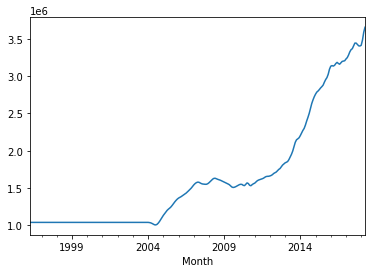

In [166]:
zip_df[11217].plot()

In [167]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

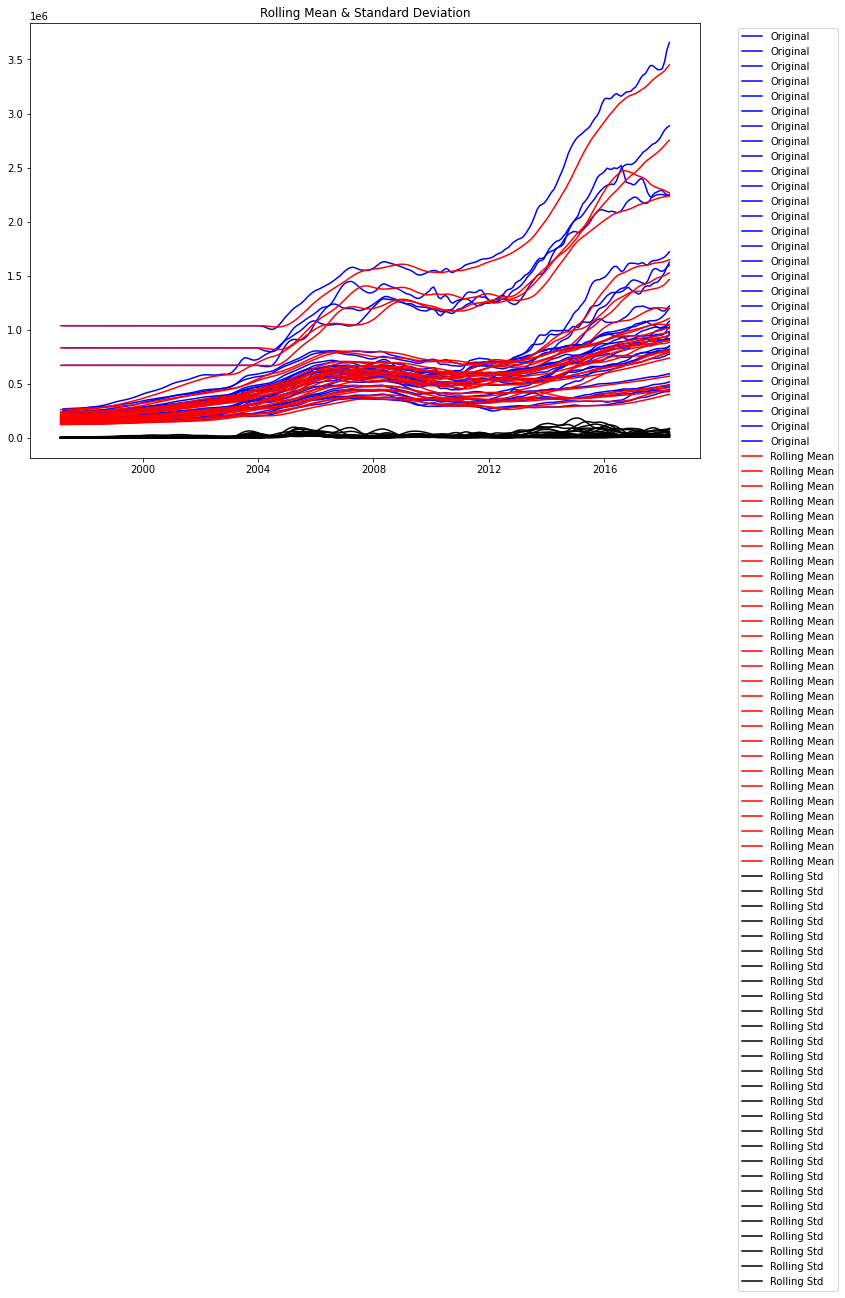

In [168]:
test_stationarity_1(zip_df,12)

### Dickey for DF

In [243]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [245]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

(0.6254102589740158, 0.9882254867110694, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 4684.550681605726)
Results of Dickey-Fuller Test:
(-0.8284459621478661, 0.8106231633355563, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4266.968811034178)
Results of Dickey-Fuller Test:
(0.22360376648978553, 0.973554814904793, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 4500.304053483356)
Results of Dickey-Fuller Test:
(-1.1262840476774874, 0.7044771402246071, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4532.017480354275)
Results of Dickey-Fuller Test:
(-0.8616429826418738, 0.8003414457926941, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 3989.3219246723397)
Results of Dickey-Fuller Test:
(-0.002947770640627667, 0.9582876275232706, 13, 251, {'1%': -3.456674451455301

In [247]:
new_dic[11214]

Test Statistic                  -0.002948
p-value                          0.958288
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64

In [252]:
#stepwise_fit_1 = arima_model(new_dic[11214])

In [170]:
"""
test_dict = {}
for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips

"""
"""
def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n') 
"""  
def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [171]:
dickey_fuller_test_zipcodes(zip_df)

Results of Dickey-Fuller Test:
Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -0.828446
p-value                          0.810623
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                   0.223604
p-value                          0.973555
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -

In [172]:
X_1 = zip_df.copy()

In [173]:
# #stepwise_fit = arima_model(zip_df)

# #history = [x for x in train_brk]
# """
# predictions = []
# for t in range(len(train_brk)):
#     model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
# """

# dict_org = {}
# dict_pred = {}

# for col in X_1:
#     size = int(len(X_1) * 0.70)
#     train, testdata = X_1[0:size], X_1[size:len(X_1)]
#     history = [x for x in train[col]]
#     predictions = list()

#     for column in testdata:
#         model = pm.auto_arima(history, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True) # this works 

#         output = model.predict()

#         yhat = output[0]
#         predictions.append(yhat)
#         obs = testdata[column]
#         history.append(obs)
#         print("Predicted:%f, expected:%f" %(yhat, obs))

#         error = mean_squared_error(testdata, predictions[:len(testdata)])
#     print('Test MSE: %.3f' % error)

#     dict_org.update({X[col]: testdata})
#     dict_pred.update({X[col]: predictions})

#     print("Item: ", X[col], "Test MSE:%f"% error)


In [248]:

dict_org = {}
dict_pred = {}

for col in X_1:
    size = int(len(X_1) * 0.70)
    train, testdata = X_1[0:size], X_1[size:len(X_1)]
    history = [x for x in train[col]]
    predictions = list()


def find_orders(ts):

    stepwise_model = pm.auto_arima(history, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) # this works 

    return stepwise_model.order, stepwise_model.seasonal_order

In [175]:
traindata, testdata = find_orders(X_1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3876.791, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4268.213, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3909.256, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3897.008, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.910 seconds


In [176]:
# for column in testdata:
#         order, seasonal_order = find_orders(ts)
#         fit_arimax(ts, order=order, seasonal_order=seasonal_order)

In [177]:
"""
history = [x for x in zip_df]
predictions = list()
predict_log=list()
for t in range(len(zip_df)):
    model = sm.tsa.SARIMAX(history,start_p=1, start_q=1,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = zip_df[t]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
"""
history = [x for x in zip_df]
predictions = list()
predict_log=list()
for t in range(len(zip_df)):
    stepwise_model = auto_arima(history, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Streaming output truncated to the last 5000 lines.
Best model:  ARIMA(1,1,0)(1,1,0)[7]          
Total fit time: 1.166 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=180.488, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=177.703, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=178.991, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=178.765, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=178.450, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=178.119, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,1)(1,1,

In [178]:
# X = zip_df
# dict_org = {}
# dict_pred = {}

# for col in X:
#     size = int(len(X) * 0.70)
#     train, testdata = X[0:size], X[size:len(X)]
#     history = [x for x in train[column]]
#     predictions = list()
    
# def find_orders(ts):

#     stepwise_model = pm.auto_arima(history, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True) # this works 

#     return stepwise_model.order, stepwise_model.seasonal_order
# find_orders(zip_df)

# for column in testdata:
#         order, seasonal_order = find_orders(ts)
#         fit_arimax(ts, order=order, seasonal_order=seasonal_order)



#     for column in testdata:
#         model = pm.auto_arima(history, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True) # this works 

#         output = model.predict()

#         yhat = output[0]
#         predictions.append(yhat)
#         predictions.append(yhat)
#         obs = testdata[column]
#         history.append(obs)
#         print("Predicted:%f, expected:%f" %(yhat, obs))

#         error = mean_squared_error(testdata, predictions[:len(testdata)])
#     print('Test MSE: %.3f' % error)

#     dict_org.update({X[col]: testdata})
#     dict_pred.update({X[col]: predictions})

#     print("Item: ", X[col], "Test MSE:%f"% error)
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     mse = evaluate_arima_model(dataset, order)
#                     if mse < best_score:
#                         best_score, best_cfg = mse, order
#                     print('ARIMA%s MSE=%.3f' % (order,mse))
#                 except:
#                     continue
#     print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [179]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.8851083655203298
p-value: 0.9928928763848232
Critical Values:
	1% : -3.4569962781990573
	5% : -2.8732659015936024
	10% : -2.573018897632674


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.885108,0.992893,16,248,False


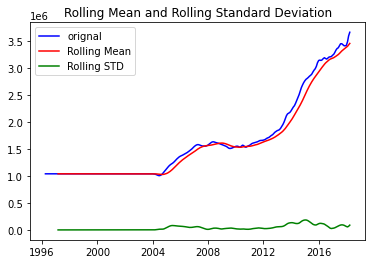

In [180]:
stationary_test(zip_df[11217])

###  Zipcode:  11238

In [181]:
#brooklyn_zips[11238]

ADF statistic: 1.3300142358520664
p-value: 0.9967718123702427
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,1.330014,0.996772,13,251,False


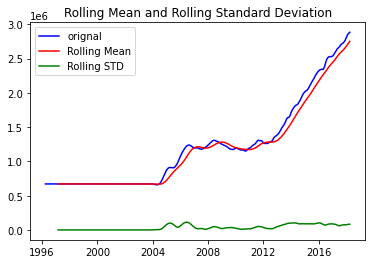

In [182]:
stationary_test(zip_df[11238])

### Zipcode:  11215

ADF statistic: 0.46462596760145564
p-value: 0.9837573347851625
Critical Values:
	1% : -3.4569962781990573
	5% : -2.8732659015936024
	10% : -2.573018897632674


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.464626,0.983757,16,248,False


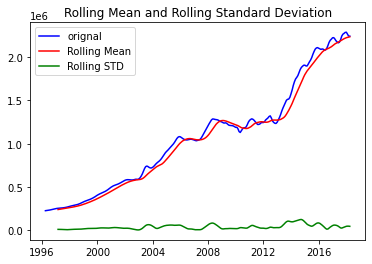

In [183]:
stationary_test(zip_df[11215])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: 0.09452306242522635
p-value: 0.9656851626501416
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.094523,0.965685,13,251,False


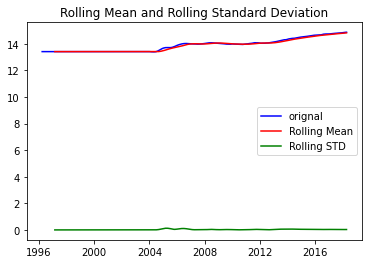

In [184]:
## Log Transform
ts3 = np.log(zip_df[11238])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -1.9076797092516766
p-value: 0.32845700267119726
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.90768,0.328457,12,251,False


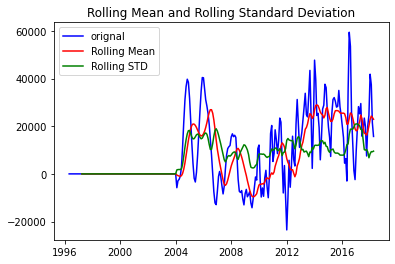

In [185]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11238].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.9071669762331716
p-value: 0.3286970868825597
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.907167,0.328697,13,249,False


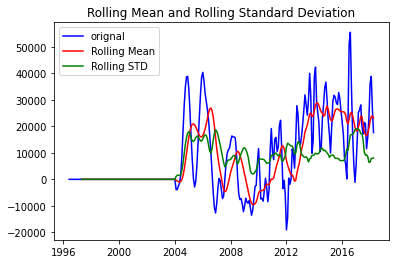

In [186]:
## Subtract Rolling mean
ts2 = (zip_df[11238] - zip_df[11238].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -1.269517236418668
p-value: 0.6430003071656732
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.269517,0.643,13,251,False


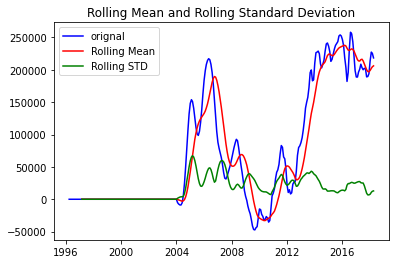

In [187]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11238] - zip_df[11238].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

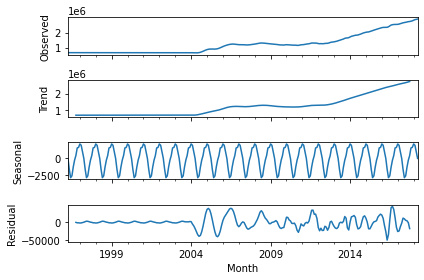

In [188]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11238])#,model='mul')
decomp.plot();

ADF statistic: -7387110690472367.0
p-value: 0.0
Critical Values:
	1% : -3.4569962781990573
	5% : -2.8732659015936024
	10% : -2.573018897632674


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-7.387111e+15,0.0,16,248,True


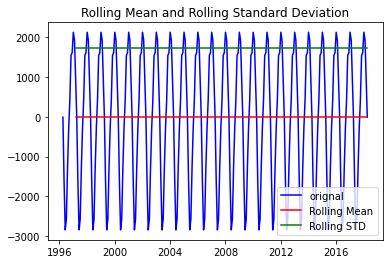

In [189]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 1.4230788215136116
p-value: 0.9972165043232114
Critical Values:
	1% : -3.4582467982399105
	5% : -2.8738137461081323
	10% : -2.5733111490323846


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,1.423079,0.997217,15,237,False


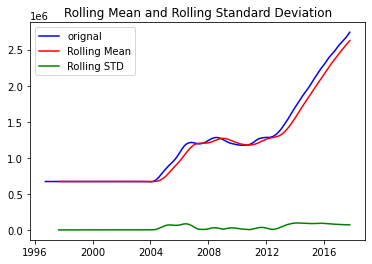

In [190]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -5.576233902155646
p-value: 1.4300620546611127e-06
Critical Values:
	1% : -3.458010773719797
	5% : -2.8737103617125186
	10% : -2.5732559963936206


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-5.576234,0.000001,13,239,True


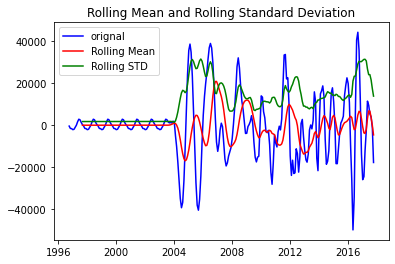

In [191]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [192]:
decomp.resid.dropna()

Month
1996-10-01     -417.286706
1996-11-01    -1543.305826
1996-12-01    -1613.940747
1997-01-01    -2127.829636
1997-02-01    -1927.035985
                  ...     
2017-06-01     9493.400523
2017-07-01     5377.924333
2017-08-01     3973.162428
2017-09-01    -1224.853445
2017-10-01   -17713.120040
Freq: MS, Name: 11238, Length: 253, dtype: float64

### GridSearch 

#### Find the values of ARIMA(p,d,q)(P,D,Q)s

In [193]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#### Identify the set of parameters that will produce the best fitting model to time series dataset.

In [194]:
"""
(AIC) is an estimator of the relative quality of statistical models for a given set of data. 
Given a collection of models for the data, AIC estimates the quality of each model, relative to each of 
    the other models. AIC provides a means for model selection.

Model that fits the data very well while using lots of features will be assigned a larger AIC score than a model
    that uses fewer features to achieve the same goodness-of-fit. 
    We are interested in finding the model that yields the lowest AIC value. 

"""
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def gridsearch_pdq(pdq, pdqs, df):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
                
            except:
                continue
    
    
    
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    #ans_df.loc[ans_df['aic'].idxmin()]

    
    return ans_df           

In [195]:
gs_pdq = gridsearch_pdq(pdq, pdqs,zip_df[11238])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =8213.126218595695
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7690.372385619281
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6770.362307042525
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =6461.448054351488
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6590.012697927848
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6560.483561757092
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =6283.456480602297
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6257.929031462257
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7991.82374884682
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7585.480247268328
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6907.405815506816
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =2265443.344976937
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =8241.977606347804
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =8074.0448694660745
ARIMA (0, 0, 1) x (1

In [196]:
gs_pdq.sort_values(by='aic')

,pdq,pdqs,aic
63,"(1, 1, 1)","(1, 1, 1, 12)",5.013629e+03
59,"(1, 1, 1)","(0, 1, 1, 12)",5.018709e+03
62,"(1, 1, 1)","(1, 1, 0, 12)",5.048530e+03
54,"(1, 1, 0)","(1, 1, 0, 12)",5.062416e+03
55,"(1, 1, 0)","(1, 1, 1, 12)",5.065884e+03
...,...,...,...
8,"(0, 0, 1)","(0, 0, 0, 12)",7.991824e+03
13,"(0, 0, 1)","(1, 0, 1, 12)",8.074045e+03
0,"(0, 0, 0)","(0, 0, 0, 12)",8.213126e+03
12,"(0, 0, 1)","(1, 0, 0, 12)",8.241978e+03


In [197]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(gs_pdq, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           5013.63
Name: 63, dtype: object

### Creating a SARIMA TS Model

In [198]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.



# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(brooklyn_zips[11238], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6873      0.045     15.420      0.000       0.600       0.775
ma.L1          0.3540      0.031     11.303      0.000       0.293       0.415
ar.S.L12      -0.3288      0.071     -4.603      0.000      -0.469      -0.189
ma.S.L12      -0.0368      0.058     -0.633      0.527      -0.151       0.077
sigma2      8.221e+07   2.84e-10    2.9e+17      0.000    8.22e+07    8.22e+07


MODEL DIAGNOSTICS


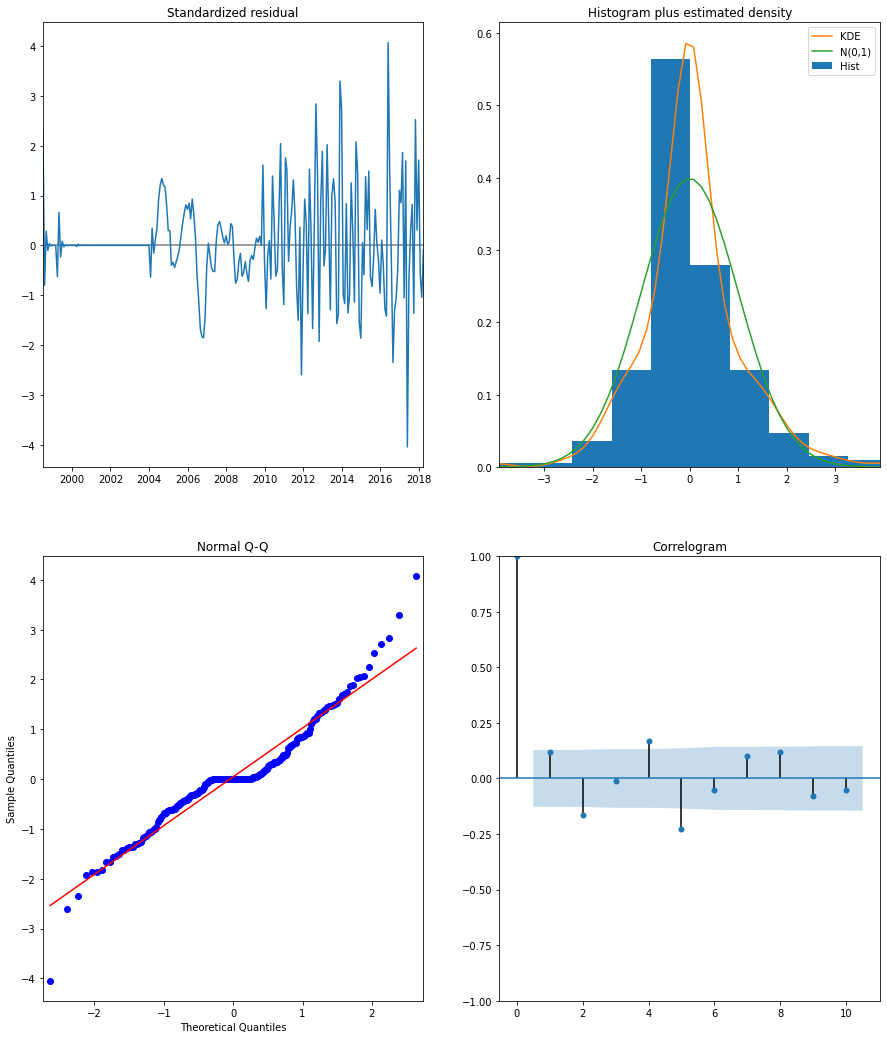

In [199]:
output_summ = fit_ARIMA(zip_df[11238], order=(1,1,1), seasonal_order=(1,1,1,12))

### Validating the Model

In [200]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

In [201]:
"""
start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

plot the real and forecasted values of the time series to assess how well we did

"""
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

In [202]:
pred_conf

,lower 11238,upper 11238
Month,,
2016-01-01,2.311733e+06,2.347275e+06
2016-02-01,2.312395e+06,2.393185e+06
2016-03-01,2.302481e+06,2.429480e+06
2016-04-01,2.305329e+06,2.476974e+06
2016-05-01,2.311142e+06,2.524950e+06
2016-06-01,2.314008e+06,2.567266e+06
2016-07-01,2.320503e+06,2.610569e+06
2016-08-01,2.331039e+06,2.655468e+06
2016-09-01,2.343588e+06,2.700179e+06


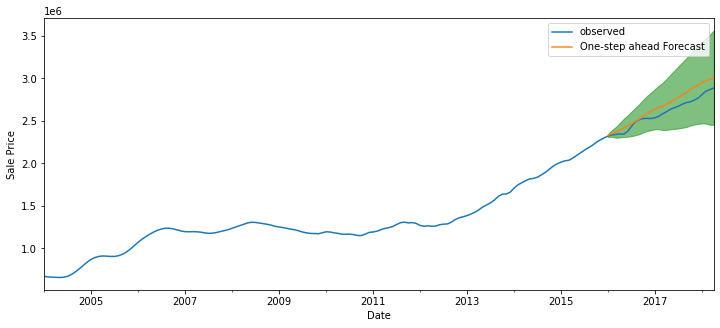

In [203]:
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [204]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = zip_df[11238]['2004':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 8750875016.43
The Root Mean Squared Error of our forecasts is 93546.11


In [205]:
"""
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()
"""
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

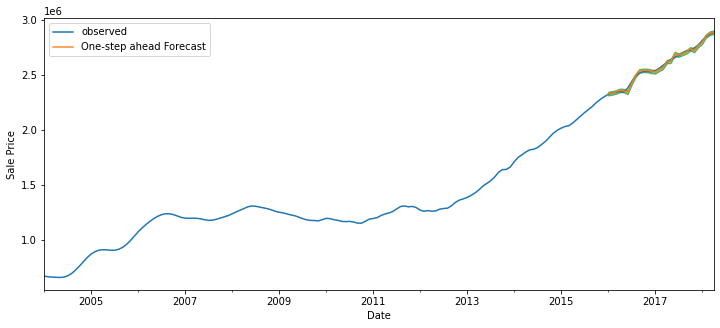

In [206]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


#### Return on Investment

In [207]:
investment = 40000
rent = 700
loss = 1000  #cost of 1000 per year

def roi(investment, rent, loss):
    """
    return on investment is calcualted by net_profit / investment * 100
    12 = # of months in year 
    investment part doesn't need to be touched investment amount is just capital cost of building
    """
    netprofit = rent * 12 - loss
    ROI = (netprofit / investment) * 100
    print(ROI)
    
#roi(investment, rent, loss) 
#calculated return on investment for these parameters
roi(investment, rent, loss)   

18.5
